In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram

from tracefc.io.session_directory import get_session_dir

In [2]:
# Define a class for a typical recording or set of recordings
from neuropy.core.session import ProcessData
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
animal, sess_name = 'Rose', 'training'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data2/Trace_FC/Recording_Rats/Rose/2022_06_22_training/Rose_training_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 17308.23 seconds 
duration: 4.81 hours 



# Preprocess Ephys data
Identify artifacts:  
- disconnects  
- filtering  
  
Send to event files to check in Neuroscope  
Write `dead_times.txt` file for spyking-circus and `artifacts.npy` file for my own analysis.

### Identify disconnect and motion artifacts

In [5]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=26), thresh=8, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

Existing artifact epochs file loaded
Total artifact time = 49.2 seconds


/home/bowenw/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


start        stop label  duration
0     939.0148    940.6004  None    1.5856
1    1103.8716   1105.8356  None    1.9640
2    1389.9564   1391.6828  None    1.7264
3    1655.7212   1657.6476  None    1.9264
4    1911.3700   1913.0452  None    1.6752
5    2180.1884   2182.2452  None    2.0568
6    2621.0236   2621.7036  None    0.6800
7    2831.6420   2837.1740  None    5.5320
8    5216.8460   5217.3692  None    0.5232
9    6543.5876   6544.1308  None    0.5432
10   6649.5924   6650.1252  None    0.5328
11   8877.2524   8891.8308  None   14.5784
12   9122.6420   9123.1684  None    0.5264
13  10767.3000  10768.7000  None    1.4000
14  11286.6500  11295.7556  None    9.1056
15  11573.0748  11574.7516  None    1.6768
16  11913.6764  11914.1948  None    0.5184
17  12984.9236  12986.5348  None    1.6112
18  13770.0000  13771.0000  None    1.0000

<Axes: >

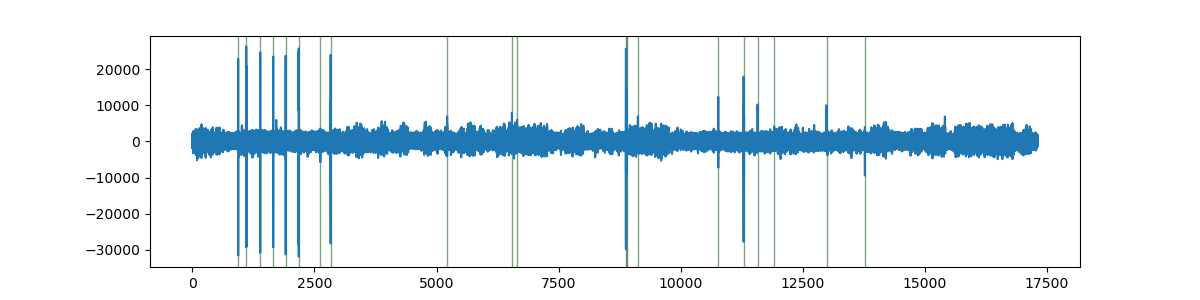

In [6]:
%matplotlib widget

chan_plot = 25
plot_signal_w_epochs(signal, chan_plot, art_epochs)

## Define probe group

/data2/Trace_FC/Recording_Rats/Rose/2022_06_22_training/Rose_training_denoised.probegroup.npy saved


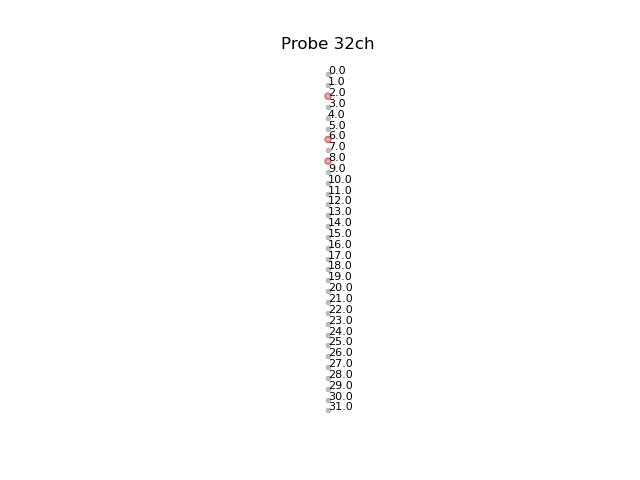

In [7]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=50, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

### Read in behavioral data

In [65]:
sess.basepath

PosixPath('/data2/Trace_FC/Recording_Rats/Rose/2022_06_22_training')

In [68]:
import neuropy.io.miniscopeio as miniio
sess.mini = miniio.MiniscopeIO(basedir=sess.basepath)
sess.mini.load_all_orientation()

including folder /data2/Trace_FC/Recording_Rats/Rose/2022_06_22_training/1_tone_habituation/tone_habituation/Rose/gobears/2022_06_22/12_13_59
including folder /data2/Trace_FC/Recording_Rats/Rose/2022_06_22_training/2_training/training/Rose/gobears/2022_06_22/12_26_01
including folder /data2/Trace_FC/Recording_Rats/Rose/2022_06_22_training/2_training/training/Rose/gobears/2022_06_22/12_36_09
including folder /data2/Trace_FC/Recording_Rats/Rose/2022_06_22_training/3_post/post/Rose/gobears/2022_06_22/13_03_27
including folder /data2/Trace_FC/Recording_Rats/Rose/2022_06_22_training/3_post/post/Rose/gobears/2022_06_22/13_10_22
including folder /data2/Trace_FC/Recording_Rats/Rose/2022_06_22_training/3_post/post/Rose/gobears/2022_06_22/13_25_35
including folder /data2/Trace_FC/Recording_Rats/Rose/2022_06_22_training/3_post/post/Rose/gobears/2022_06_22/13_46_18
including folder /data2/Trace_FC/Recording_Rats/Rose/2022_06_22_training/3_post/post/Rose/gobears/2022_06_22/13_55_00
including folder

In [69]:
sess.mini.orient_all

Time Stamp (ms)        qw        qx        qy        qz  \
0                  -1 -0.968323 -0.141541 -0.153564  0.136658   
1                  91 -0.968994 -0.125977 -0.164124  0.135010   
2                 134 -0.966736 -0.158569 -0.152832  0.130127   
3                 202 -0.964355 -0.174316 -0.135193  0.146179   
4                 268 -0.931458 -0.263611 -0.097839  0.230896   
...               ...       ...       ...       ...       ...   
4399           296332  0.712585  0.047058  0.096619  0.693298   
4400           296399  0.712524  0.047180  0.096741  0.693359   
4401           296467  0.712524  0.047180  0.096741  0.693359   
4402           296534  0.712280  0.047363  0.096802  0.693604   
4403           296601  0.712036  0.047669  0.096985  0.693787   

                  Timestamps      roll     pitch       yaw  
0    2022-06-22 12:13:59.811  0.249049  0.342758 -0.237070  
1    2022-06-22 12:13:59.903  0.215152  0.359800 -0.237598  
2    2022-06-22 12:13:59.946  0.287301  0.343478 -0.217436  
3    2022-06-22 12:14:00.014  0.317546  0.316993 -0.249701  
4    2022-06-22 12:14:00.080  0.487090  0.308889 -0.408644  
...                      ...       ...       ...       ...  
4399 2022-06-22 17:16:54.169  0.202957  0.072512  1.550737  
4400 2022-06-22 17:16:54.236  0.203314  0.072496  1.550954  
4401 2022-06-22 17:16:54.304  0.203314  0.072496  1.550954  
4402 2022-06-22 17:16:54.371  0.203689  0.072257  1.551660  
4403 2022-06-22 17:16:54.438  0.204404  0.072031  1.552240  

[171524 rows x 9 columns]

In [75]:
import neuropy.io.dlcio as dlcio
sess.dlc = dlcio.DLC(sess.basepath)

Using tracking file #1: /data2/Trace_FC/Recording_Rats/Rose/2022_06_22_training/2_training/training/Rose/gobears/2022_06_22/12_26_01/My_WebCam/Rose_training_combined_movieDLC_resnet50_TraceFC_shockboxFeb28shuffle1_500000.h5
Using tracking file #2: /data2/Trace_FC/Recording_Rats/Rose/2022_06_22_training/2_training/training/Rose/gobears/2022_06_22/12_36_09/My_WebCam/Rose_training_combined_movie2DLC_resnet50_TraceFC_shockboxFeb28shuffle1_500000.h5
Multiple videos found - taking mean sample rate from all videos


In [81]:
sess.dlc.pos_smooth

bodyparts nose                   left_ear                right_ear      \
coords       x   y    likelihood        x   y likelihood         x   y   
0          NaN NaN  7.113210e-07      NaN NaN   0.000003       NaN NaN   
1          NaN NaN  6.413760e-07      NaN NaN   0.000003       NaN NaN   
2          NaN NaN  6.391705e-07      NaN NaN   0.000002       NaN NaN   
3          NaN NaN  7.139749e-07      NaN NaN   0.000002       NaN NaN   
4          NaN NaN  7.526271e-07      NaN NaN   0.000002       NaN NaN   
...        ...  ..           ...      ...  ..        ...       ...  ..   
35407      NaN NaN  1.363064e-04      NaN NaN   0.000032       NaN NaN   
35408      NaN NaN  1.566192e-04      NaN NaN   0.000043       NaN NaN   
35409      NaN NaN  1.782613e-04      NaN NaN   0.000041       NaN NaN   
35410      NaN NaN  1.823005e-04      NaN NaN   0.000041       NaN NaN   
35411      NaN NaN  1.464634e-04      NaN NaN   0.000040       NaN NaN   

bodyparts               crown_middle  ... back_middle tail_base      \
coords       likelihood            x  ...  likelihood         x   y   
0          1.274002e-06          NaN  ...    0.000005       NaN NaN   
1          1.299100e-06          NaN  ...    0.000004       NaN NaN   
2          9.254778e-07          NaN  ...    0.000004       NaN NaN   
3          9.536798e-07          NaN  ...    0.000003       NaN NaN   
4          9.563008e-07          NaN  ...    0.000003       NaN NaN   
...                 ...          ...  ...         ...       ...  ..   
35407      2.350409e-02          NaN  ...    1.000000       NaN NaN   
35408      2.452304e-02          NaN  ...    1.000000       NaN NaN   
35409      1.733008e-02          NaN  ...    1.000000       NaN NaN   
35410      3.297295e-02          NaN  ...    1.000000       NaN NaN   
35411      2.697024e-02          NaN  ...    1.000000       NaN NaN   

bodyparts            tail_middle                tail_end            \
coords    likelihood           x   y likelihood        x         y   
0           0.000007         NaN NaN   0.000001      NaN -0.490446   
1           0.000006         NaN NaN   0.000002      NaN -0.542721   
2           0.000004         NaN NaN   0.000002      NaN -0.636971   
3           0.000005         NaN NaN   0.000002      NaN -0.323924   
4           0.000005         NaN NaN   0.000002      NaN -0.439879   
...              ...         ...  ..        ...      ...       ...   
35407       0.998481         NaN NaN   0.168771      NaN       NaN   
35408       0.998567         NaN NaN   0.144072      NaN       NaN   
35409       0.997699         NaN NaN   0.041942      NaN       NaN   
35410       0.998943         NaN NaN   0.116846      NaN       NaN   
35411       0.998764         NaN NaN   0.130328      NaN       NaN   

bodyparts                
coords       likelihood  
0          1.690813e-06  
1          1.705972e-06  
2          1.130532e-06  
3          9.623749e-07  
4          8.869127e-07  
...                 ...  
35407      1.601511e-03  
35408      1.429463e-03  
35409      6.576389e-04  
35410      7.774904e-04  
35411      1.289116e-03  

[46958 rows x 27 columns]

In [86]:
sess.dlc.SampleRate

60.0

In [92]:
sess.dlc.get_timestamps()

No Optitrack csv file found at Rose_training_combined_movieDLC_resnet50_TraceFC_shockboxFeb28shuffle1_500000.
Inferring start time from file name. SECOND PRECISION IN START TIME!!!


AttributeError: 'NoneType' object has no attribute 'group'

In [85]:
sess.dlc.pos_smooth["crown_middle"]

coords   x   y  likelihood
0      NaN NaN    0.000004
1      NaN NaN    0.000004
2      NaN NaN    0.000003
3      NaN NaN    0.000003
4      NaN NaN    0.000002
...     ..  ..         ...
35407  NaN NaN    1.000000
35408  NaN NaN    1.000000
35409  NaN NaN    1.000000
35410  NaN NaN    1.000000
35411  NaN NaN    1.000000

[46958 rows x 3 columns]

<Axes: title={'center': 'Rose: crown_middle'}, xlabel='Time (s)', ylabel='x'>

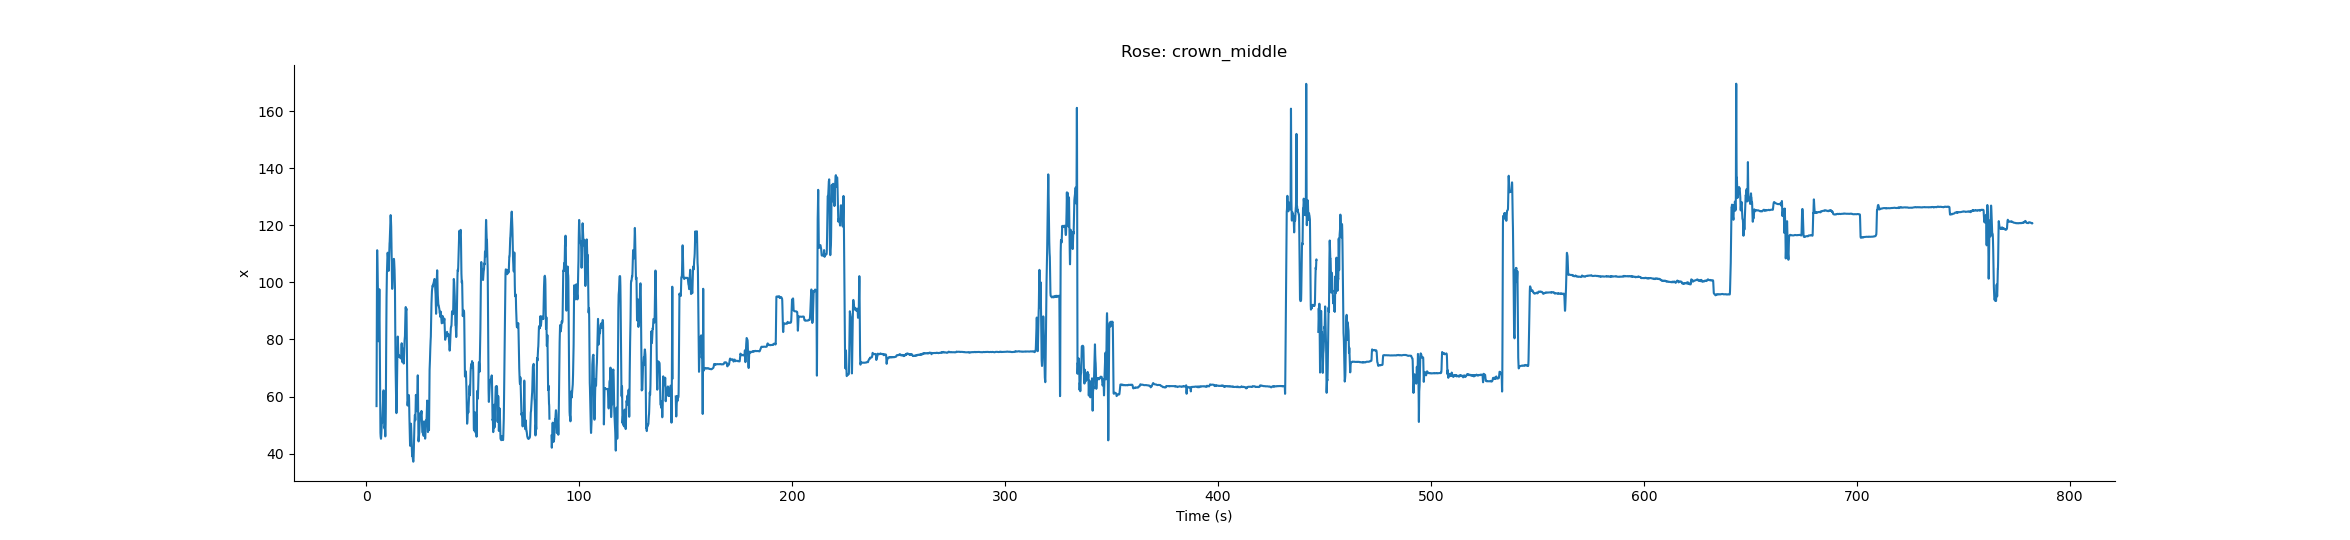

In [84]:
sess.dlc.smooth_pos()
sess.dlc.plot1d(bodyparts=["crown_middle"], data_type="smooth")

In [87]:
30*60

1800

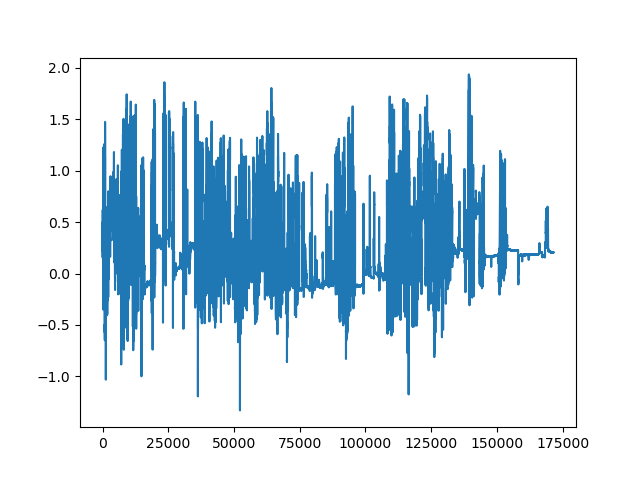

In [72]:
_, ax = plt.subplots()
dt = 
plot_signal_w_epochs(sess.mini.orient_all.reset_index()['roll'][

# Detect Theta epochs

In [8]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 25
# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
sess.recinfo.write_epochs(theta_epochs, ext='tha')
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs.save(theta_epochs_file)

Best channel for theta: [25]
1304 epochs remaining with durations within (1,20)
/data2/Trace_FC/Recording_Rats/Rose/2022_06_22_training/Rose_training_denoised.theta_epochs.npy saved


<Axes: >

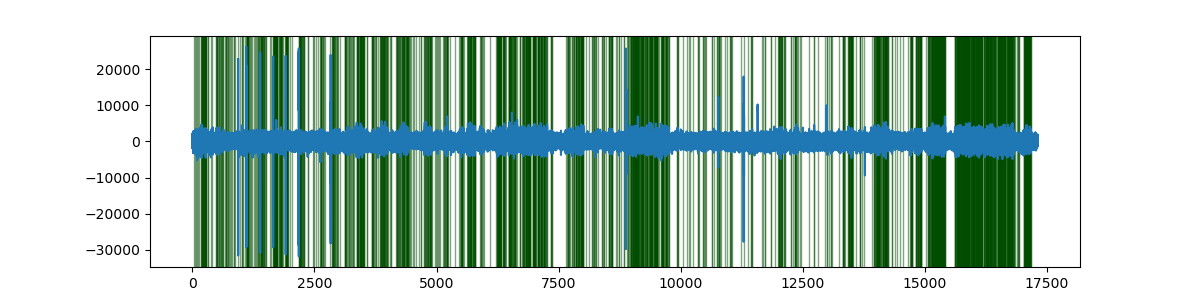

In [9]:
%matplotlib widget

chan_plot = theta_channel
plot_signal_w_epochs(signal, chan_plot, theta_epochs)

(-4000.0, 4000.0)

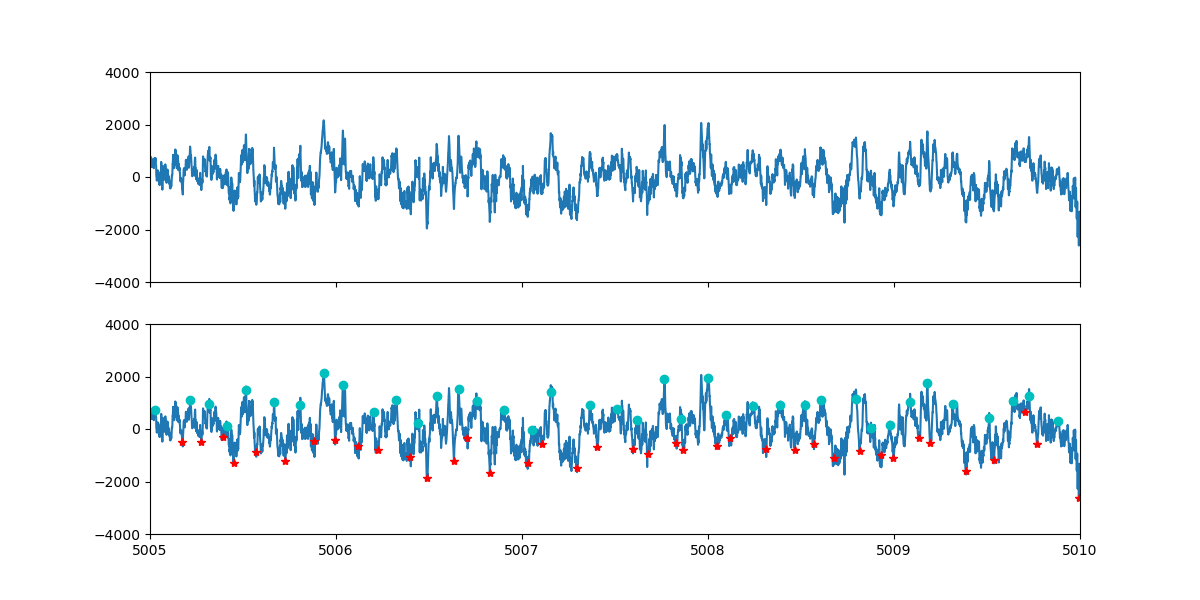

In [10]:
from neuropy.utils.signal_process import hilbert_amplitude_stat, theta_phase_specfic_extraction, ThetaParams
tparams = ThetaParams(lfp=signal.traces[theta_channel, :], fs=signal.sampling_rate, method="waveshape")
trough_indices = tparams.trough.astype(int)
peak_indices = tparams.peak.astype(int)
_, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True, sharey=True)
plot_signal_w_epochs(signal, chan_plot, theta_epochs, ax=ax[0])
ax[1].plot(signal.time, signal.traces[theta_channel])

ax[1].plot(signal.time[trough_indices], signal.traces[theta_channel, trough_indices], 'r*')
ax[1].plot(signal.time[peak_indices], signal.traces[theta_channel, peak_indices], 'co')

ax[0].set_xlim((5005, 5010))
ax[1].set_ylim((-4000, 4000))

(-4000.0, 4000.0)

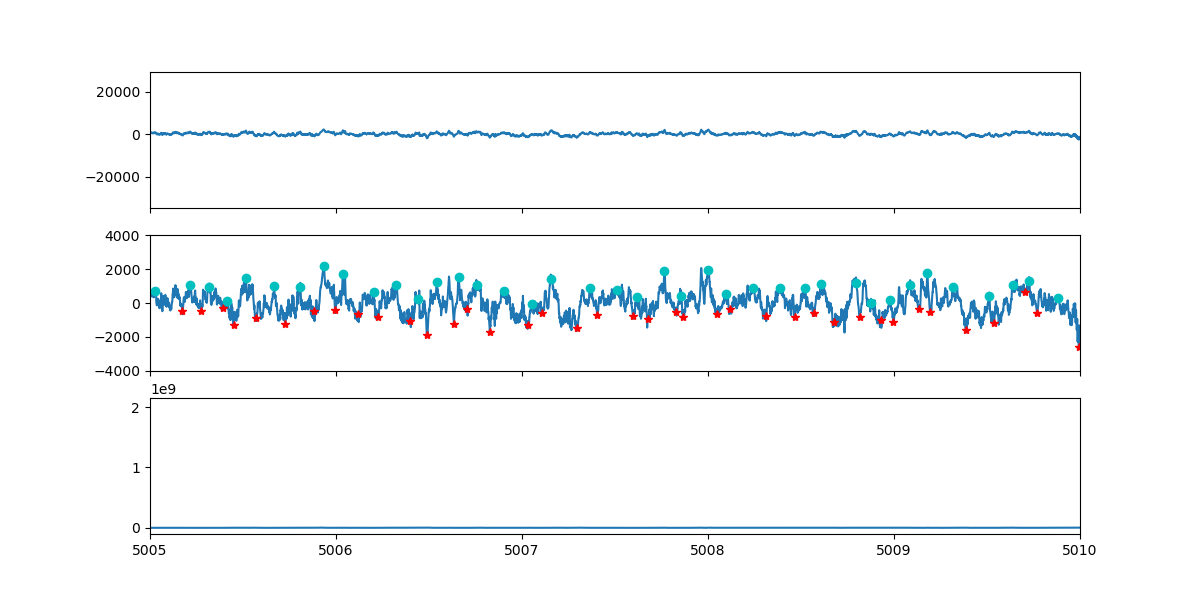

In [11]:
_, ax = plt.subplots(3, 1, figsize=(12, 6), sharex=True, sharey=False)
plot_signal_w_epochs(signal, chan_plot, theta_epochs, ax=ax[0])
ax[1].plot(signal.time, signal.traces[theta_channel])

ax[1].plot(signal.time[trough_indices], signal.traces[theta_channel, trough_indices], 'r*')
ax[1].plot(signal.time[peak_indices], signal.traces[theta_channel, peak_indices], 'co')

ax[2].plot(signal.time, tparams.amp)

ax[0].set_xlim((5005, 5010))
ax[1].set_ylim((-4000, 4000))

In [12]:
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
usv_epochs = Epoch(epochs=None, file=usv_epochs_file)
usv_epochs

43 epochs
Snippet: 
         start        stop  Begin_Time   Freq_Min  Duration  Freq_Range  Score  \
0  101.651954  101.708046  101.651954  51.053612  0.056092   10.748307      1   
1  117.878511  117.912832  117.878511  43.388889  0.034321   11.333333      1   
2  118.020568  118.071081  118.020568  30.166667  0.050513    5.000000      1   
3  121.318891  121.346269  121.318891  42.055556  0.027378   12.555556      1   
4  127.957421  127.978552  127.957421  34.722222  0.021132   10.555556      1   

   Accept  nrec  t_start_eeg  t_stop_eeg label  
0       1     1   557.388441  557.444523        
1       1     1   573.612260  573.646575        
2       1     1   573.754293  573.804797        
3       1     1   577.052060  577.079433        
4       1     1   583.689469  583.710597        

In [13]:
t_start_eeg = usv_epochs._epochs.t_start_eeg
t_start_eeg

0      557.388441
1      573.612260
2      573.754293
3      577.052060
4      583.689469
5      585.682300
6      585.722655
7      608.235905
8      618.215328
9      624.695908
10     625.205292
11     625.704545
12     626.609780
13     669.531175
14     672.518392
15     672.921716
16     691.546272
17     691.745970
18     691.802781
19     705.427060
20     706.206575
21     711.501077
22     717.901056
23     729.652174
24     736.097996
25     736.112222
26     738.110223
27     743.868186
28     749.393963
29     755.273718
30     759.689572
31     770.369415
32     807.460682
33     807.708686
34     807.742703
35     807.770515
36     860.539100
37     906.893392
38     945.980806
39     952.277498
40    1107.186484
41    1108.849759
42    1114.361801
Name: t_start_eeg, dtype: float64

In [14]:
usv_epochs.start = t_start_eeg
usv_epochs.start

0      557.388441
1      573.612260
2      573.754293
3      577.052060
4      583.689469
5      585.682300
6      585.722655
7      608.235905
8      618.215328
9      624.695908
10     625.205292
11     625.704545
12     626.609780
13     669.531175
14     672.518392
15     672.921716
16     691.546272
17     691.745970
18     691.802781
19     705.427060
20     706.206575
21     711.501077
22     717.901056
23     729.652174
24     736.097996
25     736.112222
26     738.110223
27     743.868186
28     749.393963
29     755.273718
30     759.689572
31     770.369415
32     807.460682
33     807.708686
34     807.742703
35     807.770515
36     860.539100
37     906.893392
38     945.980806
39     952.277498
40    1107.186484
41    1108.849759
42    1114.361801
Name: t_start_eeg, dtype: float64

In [15]:
t_stop_eeg = usv_epochs._epochs.t_stop_eeg
t_stop_eeg

0      557.444523
1      573.646575
2      573.804797
3      577.079433
4      583.710597
5      585.711091
6      585.744654
7      608.251655
8      618.244314
9      624.740696
10     625.215948
11     625.767258
12     626.658271
13     669.586999
14     672.585855
15     672.956498
16     691.561902
17     691.784202
18     691.833120
19     705.463376
20     706.256115
21     711.536043
22     717.920782
23     729.666884
24     736.116255
25     736.148374
26     738.161577
27     743.925919
28     749.447640
29     755.376590
30     759.775164
31     770.391627
32     807.502514
33     807.727993
34     807.756035
35     807.794419
36     860.593878
37     906.975396
38     946.029371
39     952.320343
40    1107.263264
41    1108.895699
42    1114.381786
Name: t_stop_eeg, dtype: float64

In [16]:
usv_epochs.stop = t_stop_eeg
usv_epochs.stop

0      557.444523
1      573.646575
2      573.804797
3      577.079433
4      583.710597
5      585.711091
6      585.744654
7      608.251655
8      618.244314
9      624.740696
10     625.215948
11     625.767258
12     626.658271
13     669.586999
14     672.585855
15     672.956498
16     691.561902
17     691.784202
18     691.833120
19     705.463376
20     706.256115
21     711.536043
22     717.920782
23     729.666884
24     736.116255
25     736.148374
26     738.161577
27     743.925919
28     749.447640
29     755.376590
30     759.775164
31     770.391627
32     807.502514
33     807.727993
34     807.756035
35     807.794419
36     860.593878
37     906.975396
38     946.029371
39     952.320343
40    1107.263264
41    1108.895699
42    1114.381786
Name: t_stop_eeg, dtype: float64

## high(all) USV theta phase plots

<Axes: ylabel='Count'>

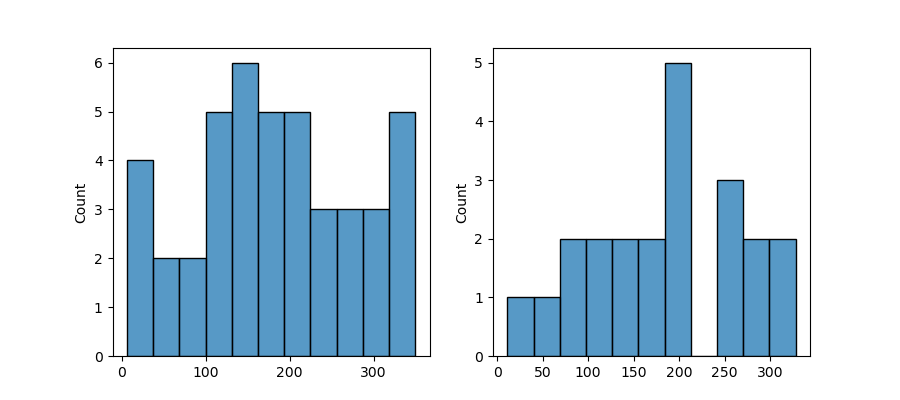

In [17]:
# First get frame number of each usv.
usv_start_frames = (usv_epochs.starts * tparams.fs).astype(int)
usv_start_frames

# Get theta power for each call start
# high_theta_usv_start_times = theta_epochs.contains(usv_epochs.starts)  # This might be too conservative
usv_start_theta_power = theta_power[usv_start_frames]

# Only include calls with above average theta power
theta_thresh = 0  # units = std (theta power is z-scored)
high_usv_power_bool = usv_start_theta_power > theta_thresh
high_theta_usv_start_frames = usv_start_frames[high_usv_power_bool]

# Next, calculate theta phase angle at each usv start
phase_start = tparams.angle[usv_start_frames]
high_theta_phase_start = tparams.angle[high_theta_usv_start_frames]

# Plot histogram of usv start angles
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.histplot(phase_start, binwidth=30, ax=ax[0])
sns.histplot(high_theta_phase_start, binwidth=30, ax=ax[1])

## high/low USV and theta epoch plot

/tmp/ipykernel_3303021/3970258888.py:22: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((start_time, 0.6), end_time - start_time, 0.4, color='blue', edgecolor='none', alpha=0.5)
/tmp/ipykernel_3303021/3970258888.py:29: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((start_time, 0.1), end_time - start_time, 0.4, color='green', edgecolor='none', alpha=0.5)


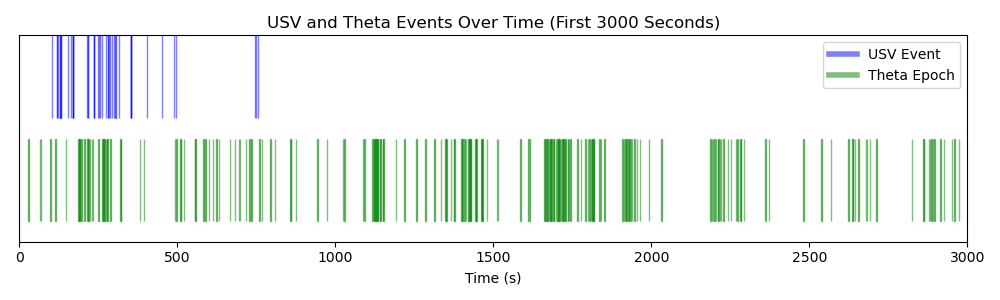

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Assuming usv_epochs and theta_epochs are defined elsewhere
usv_start_times = usv_epochs.starts
usv_stop_times = usv_epochs.stops
usv_durations = usv_epochs.stops - usv_epochs.starts

theta_start_times = theta_epochs.starts
theta_stop_times = theta_epochs.stops
theta_durations = theta_stop_times - theta_start_times

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 3))

# Plot USV events but only those within the first 3000 seconds
for start_time, duration in zip(usv_start_times, usv_durations):
    if start_time <= 3000:  # Check if the event starts within the first 3000 seconds
        end_time = min(start_time + duration, 3000)  # Ensure the event does not extend beyond 3000 seconds
        rect = Rectangle((start_time, 0.6), end_time - start_time, 0.4, color='blue', edgecolor='none', alpha=0.5)
        ax.add_patch(rect)

# Plot Theta epochs but only those within the first 3000 seconds
for start_time, duration in zip(theta_start_times, theta_durations):
    if start_time <= 3000:  # Check if the epoch starts within the first 3000 seconds
        end_time = min(start_time + duration, 3000)  # Ensure the epoch does not extend beyond 3000 seconds
        rect = Rectangle((start_time, 0.1), end_time - start_time, 0.4, color='green', edgecolor='none', alpha=0.5)
        ax.add_patch(rect)

# Legend
custom_lines = [Line2D([0], [0], color='blue', lw=4, alpha=0.5), Line2D([0], [0], color='green', lw=4, alpha=0.5)]
ax.legend(custom_lines, ['USV Event', 'Theta Epoch'])

# Set the x-axis limit to 3000 seconds
ax.set_xlim(0, 3000)
ax.set_ylim(0, 1)
ax.set_xlabel('Time (s)')
ax.set_yticks([])
plt.title('USV and Theta Events Over Time (First 3000 Seconds)')
plt.tight_layout()
plt.show()

In [19]:
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_usv_on_times = [theta_epochs.stops, usv_epochs.starts]
theta_off_usv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_usv_on_times)])
theta_off_usv_on_times = np.hstack(theta_off_usv_on_times)
sort_ids = np.argsort(theta_off_usv_on_times)

theta_off_usv_on_times = theta_off_usv_on_times[sort_ids]
theta_off_usv_on_ids = theta_off_usv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_usv_on_times, theta_off_usv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)

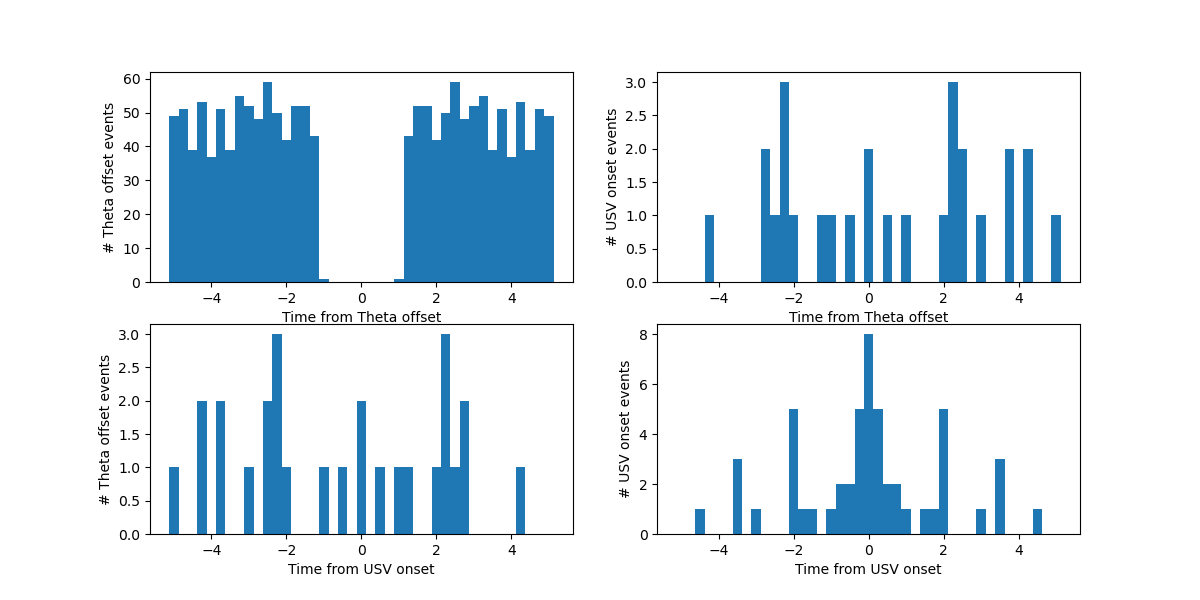

In [20]:
# Sample plotting code
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
_, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['Theta offset', 'USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")

In [21]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 25
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
exclude_theta_epochs = False  # make this true if you end up with a lot of false positive ripples as gamma events during theta

if not exclude_theta_epochs:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff, ignore_epochs=art_epochs)
else:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff,
                                         ignore_epochs=art_epochs.__add__(theta_epochs))
sess.recinfo.write_epochs(ripple_epochs, ext='swr')
ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
ripple_epochs.save(ripple_epochs_file)

Selected channels for ripples: [25]
17369 epochs remaining with durations within (0.05,0.45)
/data2/Trace_FC/Recording_Rats/Rose/2022_06_22_training/Rose_training_denoised.ripple_epochs.npy saved


In [22]:
# Convert ripple epochs to binned ripple rate
t, rip_bool = ripple_epochs.to_point_process()
from neuropy.core.neurons import BinnedSpiketrain, Neurons
rips = Neurons(t[None, rip_bool], t_stop=50*60)

In [23]:
bin_size_sec = 10
binned_rips = rips.get_binned_spiketrains(bin_size=bin_size_sec)

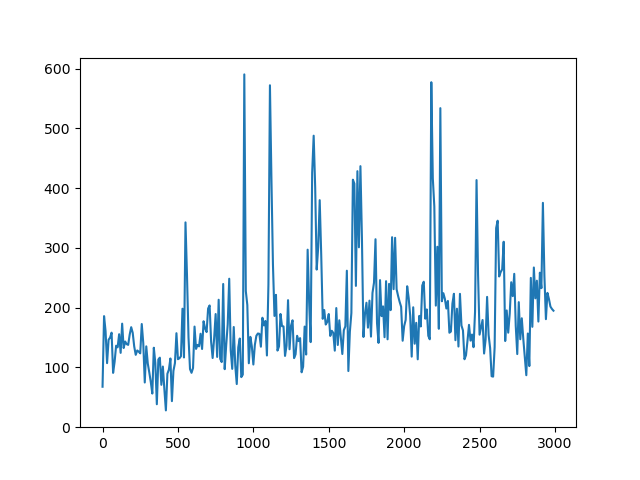

In [24]:
_, ax = plt.subplots()
ax.plot(binned_rips.time, binned_rips.firing_rate[0])

In [25]:
lowusv_epochs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min<=23]
lowusv_epochs
highusv_epochs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min>23]
highusv_epochs

start        stop  Begin_Time   Freq_Min  Duration  Freq_Range  \
0   101.651954  101.708046  101.651954  51.053612  0.056092   10.748307   
1   117.878511  117.912832  117.878511  43.388889  0.034321   11.333333   
2   118.020568  118.071081  118.020568  30.166667  0.050513    5.000000   
3   121.318891  121.346269  121.318891  42.055556  0.027378   12.555556   
4   127.957421  127.978552  127.957421  34.722222  0.021132   10.555556   
5   129.950588  129.979384  129.950588  39.969298  0.028796   10.222222   
6   129.990950  130.012953  129.990950  46.541118  0.022003    4.692982   
7   152.507999  152.523751  152.507999  25.379233  0.015753    5.555556   
8   162.489106  162.518097  162.489106  38.166667  0.028991    7.444444   
9   168.970779  169.015575  168.970779  39.833333  0.044796   11.555556   
10  169.480250  169.490907  169.480250  40.166667  0.010658    4.888889   
11  169.979586  170.042310  169.979586  38.277778  0.062724   10.000000   
12  170.884975  170.933473  170.884975  38.611111  0.048498    8.111111   
13  213.813612  213.869446  213.813612  36.611111  0.055834   10.555556   
14  216.801333  216.868808  216.801333  39.944444  0.067475   17.777778   
15  217.204726  217.239513  217.204726  41.055556  0.034787    4.666667   
16  235.832424  235.848056  235.832424  43.324492  0.015632    6.883747   
17  236.032155  236.070394  236.032155  45.981377  0.038239   15.185290   
18  236.088976  236.119321  236.088976  46.585214  0.030345   12.680587   
19  249.715554  249.751877  249.715554  34.166667  0.036323   12.333333   
20  250.495201  250.544749  250.495201  35.277778  0.049548    9.888889   
21  255.790597  255.825568  255.790597  37.944444  0.034971    8.222222   
22  262.191655  262.211384  262.191655  38.277778  0.019730    7.444444   
23  273.944756  273.959469  273.944756  54.676637  0.014713    8.574492   
24  280.391666  280.409928  280.391666  52.722222  0.018261    4.777778   
25  280.405894  280.442052  280.405894  40.055556  0.036158    7.111111   
26  282.404232  282.455595  282.404232  37.833333  0.051363    8.555556   
27  288.163167  288.220910  288.163167  37.406885  0.057743   11.093115   
28  293.689876  293.743563  293.689876  40.055556  0.053686   14.017244   
29  299.570624  299.673513  299.570624  40.277778  0.102890    8.111111   
30  303.987223  304.072829  303.987223  38.388889  0.085606   38.444444   
31  314.668868  314.691084  314.668868  45.500000  0.022215    4.777778   
32  351.766394  351.808233  351.766394  43.082957  0.041839   10.506772   
33  352.014440  352.033750  352.014440  42.237585  0.019310   15.216704   
34  352.048463  352.061796  352.048463  43.445260  0.013333   18.839729   
35  352.076279  352.100187  352.076279  49.483634  0.023908   15.941309   
36  404.853768  404.908556  404.853768  44.176323  0.054788    8.666667   
37  451.215883  451.297900  451.215883  41.833333  0.082017   29.666667   
38  490.309893  490.358466  490.309893  39.179094  0.048573    4.222222   
39  496.607648  496.650499  496.607648  41.722222  0.042851    3.777778   
40  746.745588  746.822381  746.745588  38.604898  0.076793    7.444444   
41  748.409143  748.455092  748.409143  36.283991  0.045948   27.087905   
42  753.922116  753.942104  753.922116  43.959978  0.019988   22.189570   

    Score  Accept  nrec  t_start_eeg   t_stop_eeg label  
0       1       1     1   557.388441   557.444523        
1       1       1     1   573.612260   573.646575        
2       1       1     1   573.754293   573.804797        
3       1       1     1   577.052060   577.079433        
4       1       1     1   583.689469   583.710597        
5       1       1     1   585.682300   585.711091        
6       1       1     1   585.722655   585.744654        
7       1       1     1   608.235905   608.251655        
8       1       1     1   618.215328   618.244314        
9       1       1     1   624.695908   624.740696        
10      1       1     1   625.205292   625.215948        
11      1   

## All theta USV ccg

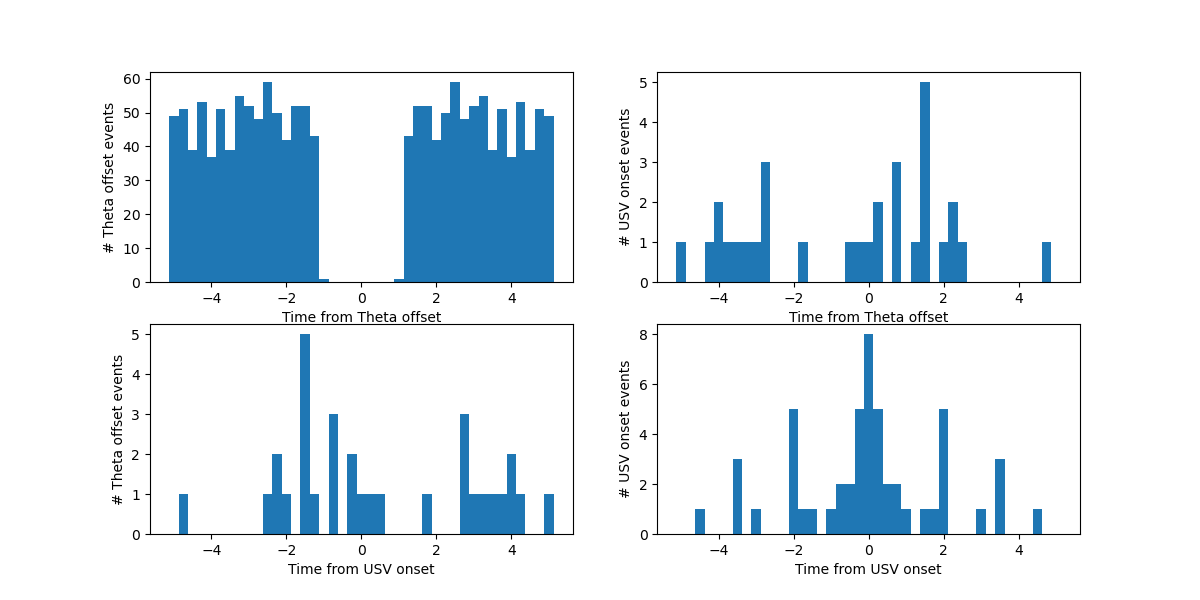

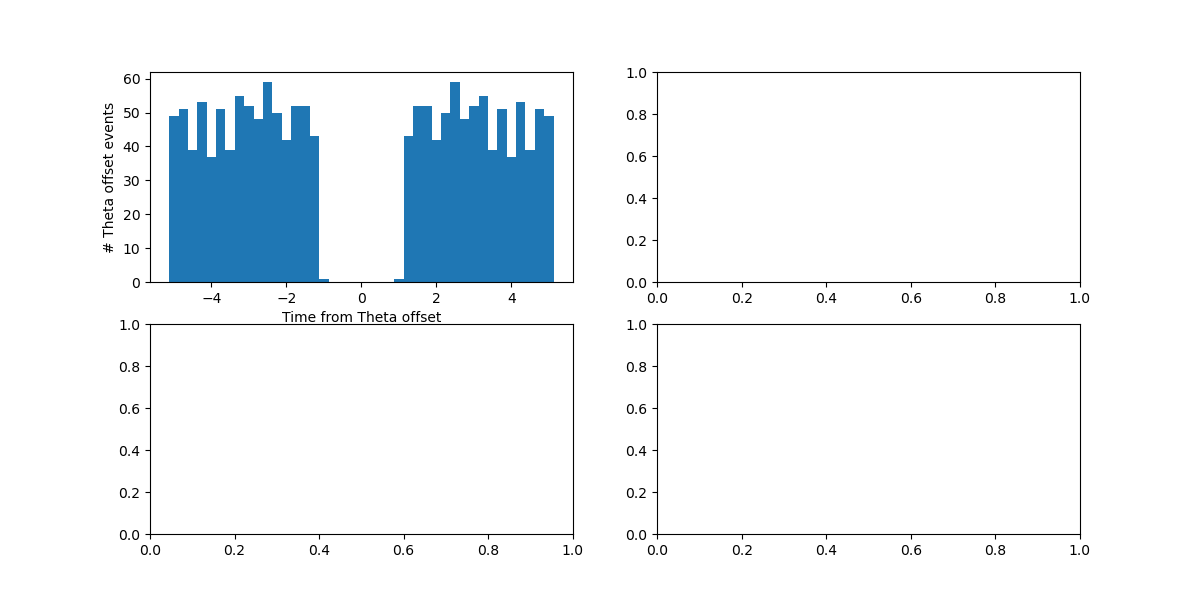

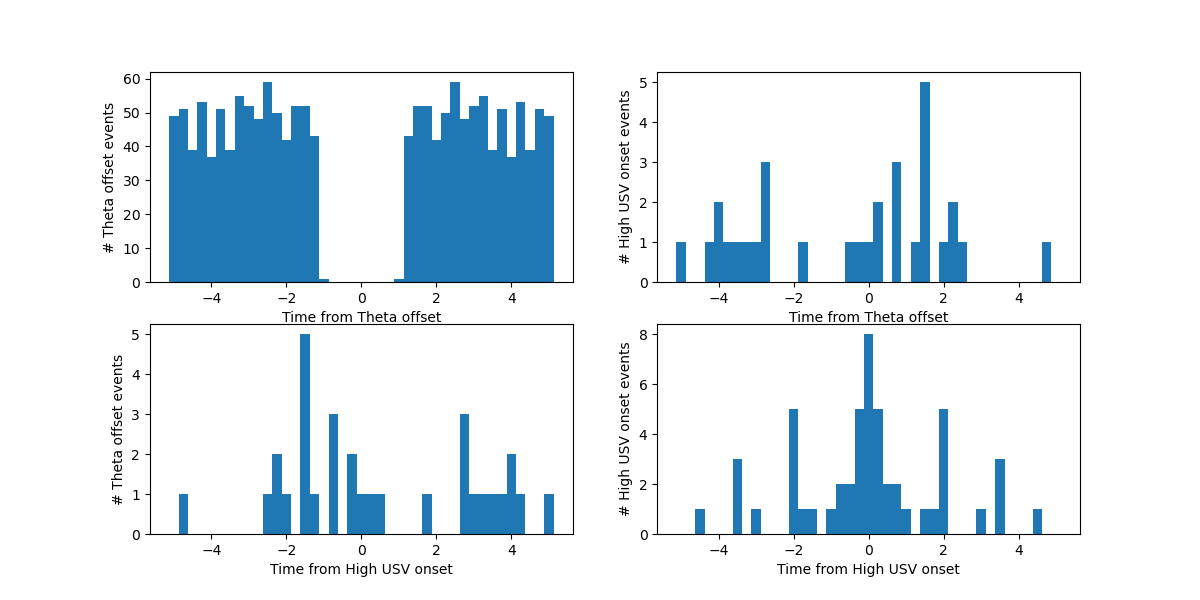

In [26]:
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_usv_on_times = [theta_epochs.stops, usv_epochs._epochs.t_start_eeg]
theta_off_usv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_usv_on_times)])
theta_off_usv_on_times = np.hstack(theta_off_usv_on_times)
sort_ids = np.argsort(theta_off_usv_on_times)

theta_off_usv_on_times = theta_off_usv_on_times[sort_ids]
theta_off_usv_on_ids = theta_off_usv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_usv_on_times, theta_off_usv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr1_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['Theta offset', 'USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")

corr1_fig.savefig('/home/bowenw/Documents/thesisplots/Rose usv-theta ccg all.png')

#low usv
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_lowusv_on_times = [theta_epochs.stops, lowusv_epochs.t_start_eeg]
theta_off_lowusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_lowusv_on_times)])
theta_off_lowusv_on_times = np.hstack(theta_off_lowusv_on_times)
sort_ids = np.argsort(theta_off_lowusv_on_times)

theta_off_lowusv_on_times = theta_off_lowusv_on_times[sort_ids]
theta_off_lowusv_on_ids = theta_off_lowusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_lowusv_on_times, theta_off_lowusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr2_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['Theta offset', 'Low USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")

corr2_fig.savefig('/home/bowenw/Documents/thesisplots/Rose usv-theta ccg lowusv.png')

#high usv
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_highusv_on_times = [theta_epochs.stops, highusv_epochs.t_start_eeg]
theta_off_highusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_highusv_on_times)])
theta_off_highusv_on_times = np.hstack(theta_off_highusv_on_times)
sort_ids = np.argsort(theta_off_highusv_on_times)

theta_off_highusv_on_times = theta_off_highusv_on_times[sort_ids]
theta_off_highusv_on_ids = theta_off_highusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_highusv_on_times, theta_off_highusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr3_fig, ax = plt.subplots(2, 2, figsize=(12, 6))


var_names = ['Theta offset', 'High USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
corr3_fig.savefig('/home/bowenw/Documents/thesisplots/Rose usv-theta ccg highusv.png')

## All RIPPLE USV ccg

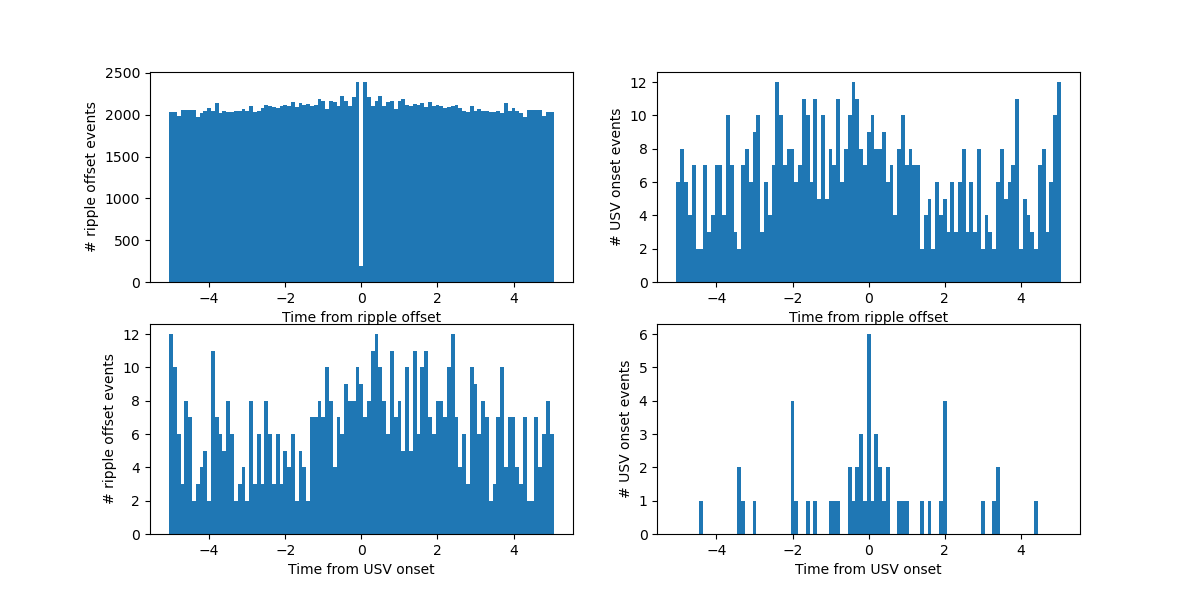

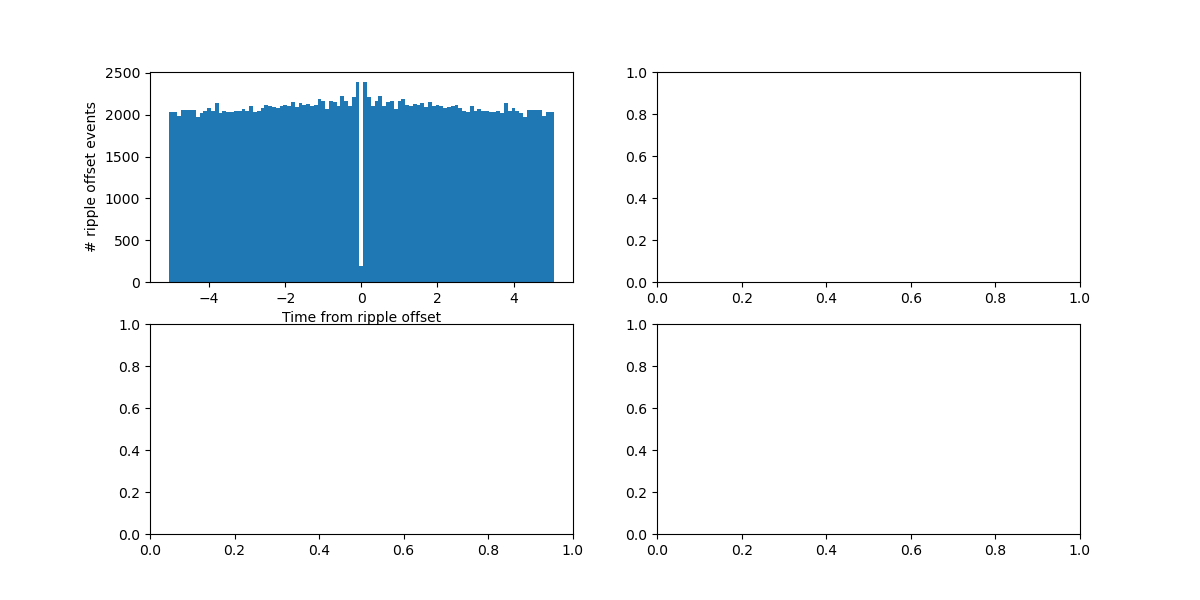

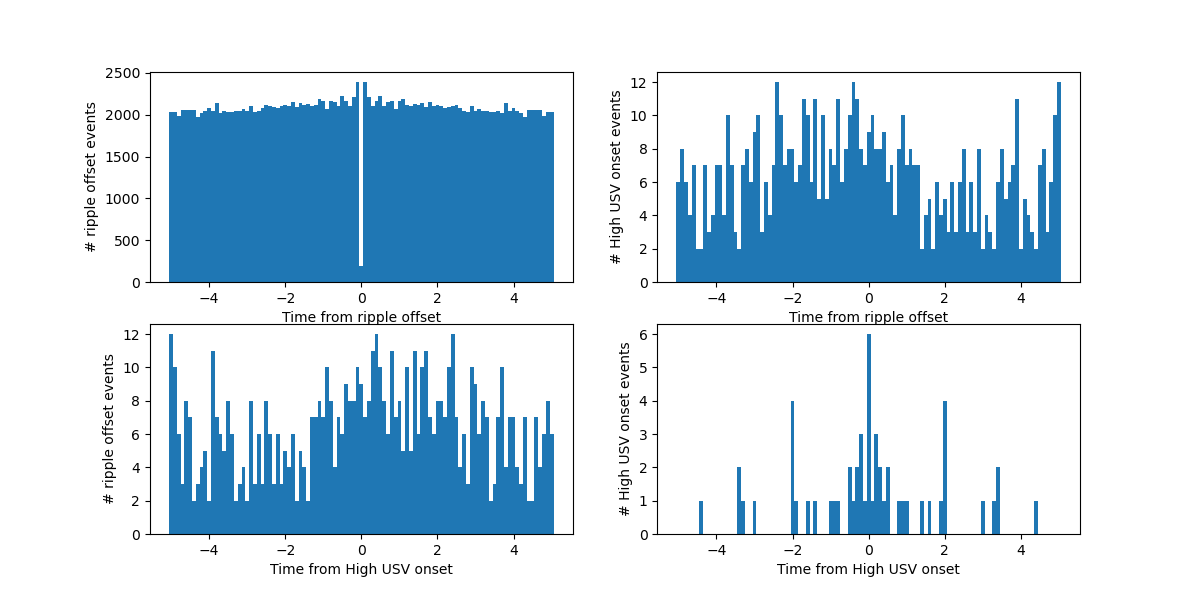

In [27]:
from neuropy.utils.ccg import correlograms

# We observe that right after ripple ends there seem to be a lot of USVs starting - check this by looking at CCG between ripple off and
# USV onset times
ripple_off_usv_on_times = [ripple_epochs.stops, usv_epochs._epochs.t_start_eeg]
ripple_off_usv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(ripple_off_usv_on_times)])
ripple_off_usv_on_times = np.hstack(ripple_off_usv_on_times)
sort_ids = np.argsort(ripple_off_usv_on_times)

ripple_off_usv_on_times = ripple_off_usv_on_times[sort_ids]
ripple_off_usv_on_ids = ripple_off_usv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.1 # seconds
ccg = correlograms(ripple_off_usv_on_times, ripple_off_usv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr4_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['ripple offset', 'USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
corr4_fig.savefig('/home/bowenw/Documents/thesisplots/Rose usv-ripple ccg all.png')

#low usv
from neuropy.utils.ccg import correlograms

# We observe that right after ripple ends there seem to be a lot of USVs starting - check this by looking at CCG between ripple off and
# USV onset times
ripple_off_lowusv_on_times = [ripple_epochs.stops, lowusv_epochs.t_start_eeg]
ripple_off_lowusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(ripple_off_lowusv_on_times)])
ripple_off_lowusv_on_times = np.hstack(ripple_off_lowusv_on_times)
sort_ids = np.argsort(ripple_off_lowusv_on_times)

ripple_off_lowusv_on_times = ripple_off_lowusv_on_times[sort_ids]
ripple_off_lowusv_on_ids = ripple_off_lowusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.1 # seconds
ccg = correlograms(ripple_off_lowusv_on_times, ripple_off_lowusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr5_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['ripple offset', 'Low USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
corr5_fig.savefig('/home/bowenw/Documents/thesisplots/Rose usv-ripple ccg lowusv.png')

#high usv
from neuropy.utils.ccg import correlograms

# We observe that right after ripple ends there seem to be a lot of USVs starting - check this by looking at CCG between ripple off and
# USV onset times
ripple_off_highusv_on_times = [ripple_epochs.stops, highusv_epochs.t_start_eeg]
ripple_off_highusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(ripple_off_highusv_on_times)])
ripple_off_highusv_on_times = np.hstack(ripple_off_highusv_on_times)
sort_ids = np.argsort(ripple_off_highusv_on_times)

ripple_off_highusv_on_times = ripple_off_highusv_on_times[sort_ids]
ripple_off_highusv_on_ids = ripple_off_highusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.1 # seconds
ccg = correlograms(ripple_off_highusv_on_times, ripple_off_highusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr6_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['ripple offset', 'High USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
corr6_fig.savefig('/home/bowenw/Documents/thesisplots/Rose usv-ripple ccg highusv.png')

## Theta power during usv/nonusv

In [28]:
# signal.time_slice(t_start=usv_epochs.starts[0], t_stop=usv_epochs.stops[0])
# theta_power_sg = core.signal.Signal(theta_power, signal.sampling_rate)
# theta_power_usvs, theta_power_non_usvs = [], []
# theta_power_sg = core.signal.Signal(theta_power, signal.sampling_rate)
# for usv_epoch, usv_next_epoch in zip(usv_epochs, usv_epochs[1:]):

#     power_slice = theta_power_sg.time_slice(t_start=usv_epoch.starts, t_stop=usv_epoch.stops)
#     theta_power_usvs.append(power_slice.traces[0].mean())

#     power_slice = theta_power_sg.time_slice(t_start=usv_epoch.starts, t_stop=usv_next_epoch.starts)
#     theta_power_non_usvs.append(power_slice.traces[0].mean())

# theta_power_usvs = np.array(theta_power_usvs)
# theta_power_non_usvs = np.array(theta_power_non_usvs)

In [29]:
# # Make above into pandas DataFrame for easy plotting with seaborn

# df1 = pd.DataFrame({"Theta Power": theta_power_usvs, "Epoch": "USV"})
# df2 = pd.DataFrame({"Theta Power": theta_power_non_usvs, "Epoch": "non-USV"})
# theta_power_df = pd.concat((df1, df2), axis=0).reset_index()
# theta_power_df

In [30]:
# # Easily plot with seaborn
# _, ax = plt.subplots()

# sns.violinplot(data=theta_power_df, x="Epoch", y="Theta Power")

In [31]:
theta_power_sg = core.signal.Signal(theta_power, signal.sampling_rate)

In [32]:
recording_duration = 3000 
theta_power_usvs = []
theta_power_non_usvs = []

for i, usv_epoch in enumerate(usv_epochs):
    # Vectorized comparison to check if any t_stop_eeg value exceeds recording_duration
    exceed_indices = usv_epoch._epochs.t_stop_eeg > recording_duration
    
    # Vectorized assignment to adjust those t_stop_eeg values
    usv_epoch._epochs.loc[exceed_indices, 't_stop_eeg'] = recording_duration

    # Assuming usv_epoch._epochs is a DataFrame and t_start_eeg, t_stop_eeg are its columns
    t_start = usv_epoch._epochs.t_start_eeg.iloc[0]  # Assuming you're working with the first row
    t_stop = min(usv_epoch._epochs.t_stop_eeg.iloc[0], recording_duration)

    # Slice theta power using adjusted start and stop times
    power_slice = theta_power_sg.time_slice(t_start=t_start, t_stop=t_stop)
    theta_power_usvs.append(power_slice.traces[0].mean())

    # Preparing for the next start comparison, handling the last epoch separately
    if i + 1 < len(usv_epochs):
        next_start = usv_epochs[i + 1]._epochs.t_start_eeg.iloc[0]
    else:
        next_start = recording_duration  # Default to recording_duration for the last epoch

    # Interval check and theta power calculation for non-USVs
    if t_stop < next_start and (next_start - t_stop) > 2:
        power_slice = theta_power_sg.time_slice(t_start=t_stop, t_stop=next_start)
        theta_power_non_usvs.append(power_slice.traces[0].mean())

# Convert lists to numpy arrays
theta_power_usvs = np.array(theta_power_usvs)
theta_power_non_usvs = np.array(theta_power_non_usvs)

# Create DataFrames and concatenate
df1 = pd.DataFrame({"Theta Power": theta_power_usvs, "Epoch": "USV"})
df2 = pd.DataFrame({"Theta Power": theta_power_non_usvs, "Epoch": "non-USV"})
theta_power_df = pd.concat([df1, df2], axis=0).reset_index(drop=True)

theta_power_df

Theta Power    Epoch
0      0.585367      USV
1     -0.214319      USV
2      0.125055      USV
3      0.417606      USV
4      1.127037      USV
..          ...      ...
65    -0.329793  non-USV
66    -0.148881  non-USV
67    -0.209674  non-USV
68     0.029848  non-USV
69     0.026044  non-USV

[70 rows x 2 columns]

<Axes: title={'center': 'Rose: Theta power during usv and non_usv\nMean USV: 0.0316, Mean non-USV: -0.0786'}, xlabel='Epoch', ylabel='Theta Power'>

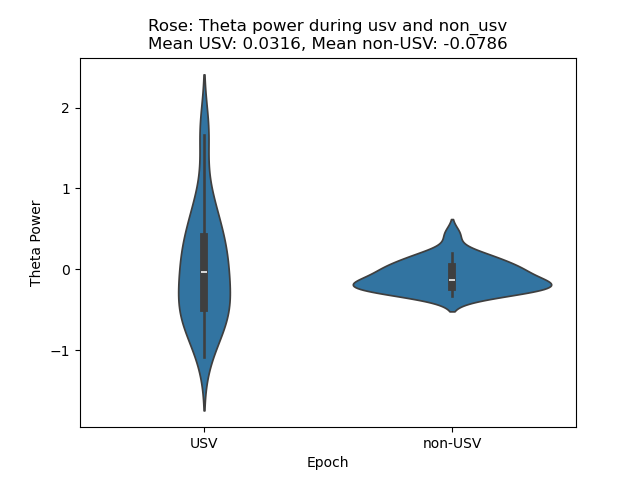

In [33]:
# Easily plot with seaborn
_, ax = plt.subplots()
title_text = f"Rose: Theta power during usv and non_usv\nMean USV: {theta_power_usvs.mean():.4f}, Mean non-USV: {theta_power_non_usvs.mean():.4f}"
ax.set_title(title_text)
sns.violinplot(data=theta_power_df, x="Epoch", y="Theta Power")

In [93]:
import neuropy.io.dlcio as dlcio
dlc_path = '/data2/Trace_FC/Recording_Rats/Rose/2022_06_22_training/2_training'
arena_side_pix = 60  # Keep this
arena_side_cm = 25.4  # Update this after measuring!!!
pix2cm = arena_side_cm / arena_side_pix

# Read in DLC data
sess.dlc = dlcio.DLC(dlc_path, pix2cm=pix2cm)

# Smooth position, get timestamps, and get speed
sess.dlc.get_timestamps('ms_webcam', include_str="2_training")
sess.dlc.smooth_pos(bodyparts=["crown_middle", "back_middle"])
sess.dlc.timestamps["Timestamps"] = sess.dlc.timestamps["Timestamps"].dt.tz_localize("America/Detroit")
sess.dlc.get_all_speed()

Using tracking file #1: /data2/Trace_FC/Recording_Rats/Rose/2022_06_22_training/2_training/training/Rose/gobears/2022_06_22/12_26_01/My_WebCam/Rose_training_combined_movieDLC_resnet50_TraceFC_shockboxFeb28shuffle1_500000.h5
Using tracking file #2: /data2/Trace_FC/Recording_Rats/Rose/2022_06_22_training/2_training/training/Rose/gobears/2022_06_22/12_36_09/My_WebCam/Rose_training_combined_movie2DLC_resnet50_TraceFC_shockboxFeb28shuffle1_500000.h5
Multiple videos found - taking mean sample rate from all videos


back_middle  crown_middle  left_ear  neck_base        nose  right_ear  \
0              NaN           NaN  1.226709   2.391726  261.377227   1.968277   
1              NaN           NaN  1.080965   2.076066  209.172905   3.431359   
2              NaN           NaN  1.827675   1.745248  406.138208   3.383266   
3              NaN           NaN  0.272942   0.707797    0.993090   3.321731   
4              NaN           NaN  0.764374   2.485206  192.990039   4.388749   
...            ...           ...       ...        ...         ...        ...   
46953          NaN           NaN  1.565803   1.618350    2.257948   2.319340   
46954          NaN           NaN  0.714827   0.810021    1.305811   0.890493   
46955          NaN           NaN  2.124886   1.251607    0.705009   1.148287   
46956          NaN           NaN  1.148412   1.806018    3.196670   2.265912   
46957          NaN           NaN       NaN        NaN         NaN        NaN   

       tail_base  tail_end  tail_middle  
0       1.780261  0.912682     0.113730  
1       2.186299  1.762160     1.176408  
2       2.679003  3.074062     1.258545  
3       1.020679  1.937704     1.105425  
4       1.492752  2.990377     2.033801  
...          ...       ...          ...  
46953   3.905382  1.475447     2.971168  
46954   5.478391  1.490844     6.178236  
46955   7.281961  1.592147     5.116955  
46956   1.312127  3.729839     4.087682  
46957        NaN       NaN          NaN  

[46958 rows x 9 columns]

In [101]:
sess.dlc.pos_smooth["back_middle"]

coords   x   y  likelihood
0      NaN NaN    0.000005
1      NaN NaN    0.000004
2      NaN NaN    0.000004
3      NaN NaN    0.000003
4      NaN NaN    0.000003
...     ..  ..         ...
35407  NaN NaN    1.000000
35408  NaN NaN    1.000000
35409  NaN NaN    1.000000
35410  NaN NaN    1.000000
35411  NaN NaN    1.000000

[46958 rows x 3 columns]

In [107]:
sess.dlc.speed

back_middle  crown_middle  left_ear  neck_base        nose  right_ear  \
0              NaN           NaN  1.226709   2.391726  261.377227   1.968277   
1              NaN           NaN  1.080965   2.076066  209.172905   3.431359   
2              NaN           NaN  1.827675   1.745248  406.138208   3.383266   
3              NaN           NaN  0.272942   0.707797    0.993090   3.321731   
4              NaN           NaN  0.764374   2.485206  192.990039   4.388749   
...            ...           ...       ...        ...         ...        ...   
46953          NaN           NaN  1.565803   1.618350    2.257948   2.319340   
46954          NaN           NaN  0.714827   0.810021    1.305811   0.890493   
46955          NaN           NaN  2.124886   1.251607    0.705009   1.148287   
46956          NaN           NaN  1.148412   1.806018    3.196670   2.265912   
46957          NaN           NaN       NaN        NaN         NaN        NaN   

       tail_base  tail_end  tail_middle  
0       1.780261  0.912682     0.113730  
1       2.186299  1.762160     1.176408  
2       2.679003  3.074062     1.258545  
3       1.020679  1.937704     1.105425  
4       1.492752  2.990377     2.033801  
...          ...       ...          ...  
46953   3.905382  1.475447     2.971168  
46954   5.478391  1.490844     6.178236  
46955   7.281961  1.592147     5.116955  
46956   1.312127  3.729839     4.087682  
46957        NaN       NaN          NaN  

[46958 rows x 9 columns]

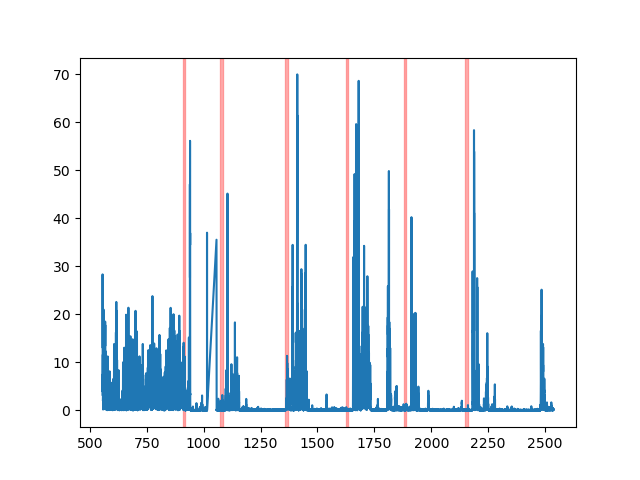

In [132]:
_, ax = plt.subplots()
# ax.plot(sess.dlc.timestamps["eeg_time"], sess.dlc.pos_smooth["back_middle"]["x"])
ax.plot(sess.dlc.timestamps["eeg_time"], sess.dlc.speed["back_middle"])
for start, stop in zip(sess.cs_epochs.starts, sess.cs_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

In [173]:
# Loop through and get speed data for each trial
speed = sess.dlc.speed["back_middle"]
eeg_time = sess.dlc.timestamps.reset_index()["eeg_time"]
buffer = [10, 40]
speed_raster = []
time_raster = []
for start, stop in zip(sess.cs_epochs.starts, sess.cs_epochs.stops):
    time_bool = (eeg_time > (start - buffer[0])) & (eeg_time < (stop + buffer[1]))
    speed_raster.append(speed[time_bool].values)
    time_raster.append(eeg_time[time_bool].values - start)

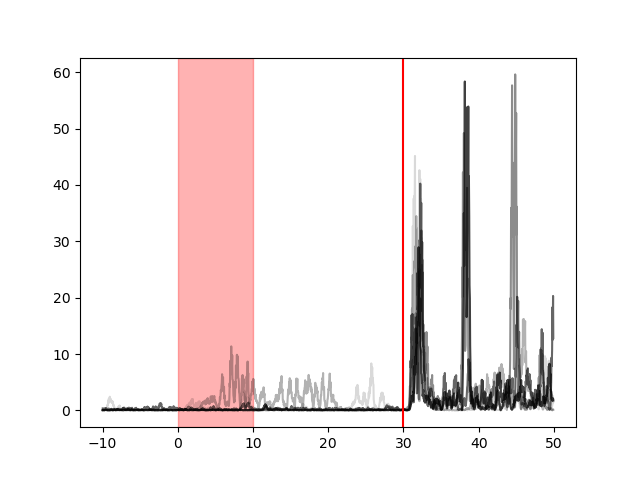

In [181]:
_, ax = plt.subplots()
for idr, (trast, rast) in enumerate(zip(time_raster, speed_raster)):
    ax.plot(trast, rast, color=[0, 0, 0, idr*0.15])
ax.axvspan(0, 10, color=[1, 0, 0, 0.3])
ax.axvline(30, color='r')

In [172]:
eeg_time[time_bool] - start

37444    -9.993841
37445    -9.941841
37446    -9.897841
37447    -9.864841
37448    -9.816841
           ...    
38872    49.734119
38873    49.775119
38874    49.814119
38875    49.862119
38876    49.900119
Name: eeg_time, Length: 1433, dtype: float64

In [134]:
sess.cs_epochs.to_dataframe()

start         stop label  duration
0   908.923874   918.842774        9.918900
1  1073.032797  1082.969264        9.936467
2  1359.114797  1369.047497        9.932700
3  1624.897497  1634.815931        9.918434
4  1880.518964  1890.454331        9.935367
5  2149.348131  2159.282797        9.934666

In [113]:
cs_epochs_file = sess.filePrefix.with_suffix(".cs_epochs.npy")
sess.cs_epochs = Epoch(epochs=None, file=cs_epochs_file)
sess.cs_epochs.starts

array([ 908.923874, 1073.032797, 1359.114797, 1624.897497, 1880.518964,
       2149.348131])

In [121]:
sess.dlc.timestamps

Frame Number  Time Stamp (ms)  Buffer Index  \
0                 0               -8             0   
1                 1               41             0   
2                 2               73             0   
3                 3              121             0   
4                 4              169             0   
...             ...              ...           ...   
35407         35407          1480659             0   
35408         35408          1480691             0   
35409         35409          1480744             0   
35410         35410          1480787             0   
35411         35411          1480819             0   

                            Timestamps  Total seconds from OE start  \
0     2022-06-22 12:26:01.657000-04:00                   737.325517   
1     2022-06-22 12:26:01.706000-04:00                   737.374517   
2     2022-06-22 12:26:01.738000-04:00                   737.406517   
3     2022-06-22 12:26:01.786000-04:00                   737.454517   
4     2022-06-22 12:26:01.834000-04:00                   737.502517   
...                                ...                          ...   
35407 2022-06-22 13:00:50.105000-04:00                  2825.773517   
35408 2022-06-22 13:00:50.137000-04:00                  2825.805517   
35409 2022-06-22 13:00:50.190000-04:00                  2825.858517   
35410 2022-06-22 13:00:50.233000-04:00                  2825.901517   
35411 2022-06-22 13:00:50.265000-04:00                  2825.933517   

          eeg_time  
0       543.130287  
1       543.179286  
2       543.211286  
3       543.259286  
4       543.307286  
...            ...  
35407  2537.016028  
35408  2537.048028  
35409  2537.101028  
35410  2537.144028  
35411  2537.176028  

[46958 rows x 6 columns]

In [127]:
sess.dlc.timestamps["eeg_time"]

0         543.130287
1         543.179286
2         543.211286
3         543.259286
4         543.307286
            ...     
35407    2537.016028
35408    2537.048028
35409    2537.101028
35410    2537.144028
35411    2537.176028
Name: eeg_time, Length: 46958, dtype: float64

In [131]:
# Hijack calcium event plotters to plot trial-by-trial behavior
from neuropy.plotting.ca_events import plot_pe_traces

plot_pe_traces(sess.dlc.timestamps["eeg_time"].values, sess.dlc.speed["back_middle"], event_starts=sess.cs_epochs.to_dataframe()["start"],
               event_ends=sess.cs_epochs.to_dataframe()["stop"])

UnboundLocalError: cannot access local variable 'start_buffers' where it is not associated with a value

In [95]:
sess.dlc.timestamps

Frame Number  Time Stamp (ms)  Buffer Index  \
0                 0               -8             0   
1                 1               41             0   
2                 2               73             0   
3                 3              121             0   
4                 4              169             0   
...             ...              ...           ...   
35407         35407          1480659             0   
35408         35408          1480691             0   
35409         35409          1480744             0   
35410         35410          1480787             0   
35411         35411          1480819             0   

                            Timestamps  
0     2022-06-22 12:26:01.657000-04:00  
1     2022-06-22 12:26:01.706000-04:00  
2     2022-06-22 12:26:01.738000-04:00  
3     2022-06-22 12:26:01.786000-04:00  
4     2022-06-22 12:26:01.834000-04:00  
...                                ...  
35407 2022-06-22 13:00:50.105000-04:00  
35408 2022-06-22 13:00:50.137000-04:00  
35409 2022-06-22 13:00:50.190000-04:00  
35410 2022-06-22 13:00:50.233000-04:00  
35411 2022-06-22 13:00:50.265000-04:00  

[46958 rows x 4 columns]

In [98]:
# Load in openephys times to sync
import neuropy.io.openephysio as oeio
sync_df = oeio.create_sync_df(sess.basepath)
sync_df["Total seconds from start"] = (sync_df["Datetime"] - sync_df["Datetime"][0]).dt.total_seconds()

# sync DLC times to your eeg file
sess.dlc.timestamps["Total seconds from OE start"] = (sess.dlc.timestamps["Timestamps"] - sync_df["Datetime"][0]).dt.total_seconds()
sess.dlc.timestamps["eeg_time"] = np.interp(sess.dlc.timestamps["Total seconds from OE start"], sync_df["Total seconds from start"], 
                                            sync_df["eeg_time"])
sess.dlc.timestamps

start time = 2022-06-22 12:13:44.331483-04:00
start time = 2022-06-22 12:25:48.054692-04:00
start time = 2022-06-22 12:35:27.787169-04:00
start time = 2022-06-22 13:03:02.922202-04:00
start time = 2022-06-22 13:10:06.192484-04:00
start time = 2022-06-22 13:54:58.035938-04:00
start time = 2022-06-22 14:54:42.076759-04:00
start time = 2022-06-22 15:35:41.591063-04:00
start time = 2022-06-22 15:41:43.879391-04:00
start time = 2022-06-22 16:07:27.767686-04:00


Frame Number  Time Stamp (ms)  Buffer Index  \
0                 0               -8             0   
1                 1               41             0   
2                 2               73             0   
3                 3              121             0   
4                 4              169             0   
...             ...              ...           ...   
35407         35407          1480659             0   
35408         35408          1480691             0   
35409         35409          1480744             0   
35410         35410          1480787             0   
35411         35411          1480819             0   

                            Timestamps  Total seconds from OE start  \
0     2022-06-22 12:26:01.657000-04:00                   737.325517   
1     2022-06-22 12:26:01.706000-04:00                   737.374517   
2     2022-06-22 12:26:01.738000-04:00                   737.406517   
3     2022-06-22 12:26:01.786000-04:00                   737.454517   
4     2022-06-22 12:26:01.834000-04:00                   737.502517   
...                                ...                          ...   
35407 2022-06-22 13:00:50.105000-04:00                  2825.773517   
35408 2022-06-22 13:00:50.137000-04:00                  2825.805517   
35409 2022-06-22 13:00:50.190000-04:00                  2825.858517   
35410 2022-06-22 13:00:50.233000-04:00                  2825.901517   
35411 2022-06-22 13:00:50.265000-04:00                  2825.933517   

          eeg_time  
0       543.130287  
1       543.179286  
2       543.211286  
3       543.259286  
4       543.307286  
...            ...  
35407  2537.016028  
35408  2537.048028  
35409  2537.101028  
35410  2537.144028  
35411  2537.176028  

[46958 rows x 6 columns]

In [36]:
# Last calculate freezing times and plot again to check
frz_thresh = 0.25 # cm/sec  Adjust this to something that looks reasonable!
duration_thresh = 2 # sec, must be below the threshold above for at least that long to be considered freezing
bodypart_use = "crown_middle"
frz_bool = sess.dlc.speed[bodypart_use] < frz_thresh
frz_epochs = Epoch.from_boolean_array(frz_bool, t=sess.dlc.timestamps["eeg_time"])
frz_df = frz_epochs.to_dataframe()
frz_df = frz_df[frz_epochs.durations > duration_thresh]

frz_epochs = Epoch(frz_df)
frz_epochs

121 epochs
Snippet: 
         start        stop  duration label
0  918.823693  921.847688  3.023995  high
1  954.872636  963.960622  9.087986  high
2  978.039599  980.807595  2.767996  high
3  980.967595  983.112591  2.144997  high
4  996.448570  998.583567  2.134997  high

## moving speed during highusv/lowusv/frz

In [37]:
# Reset index for both timestamps and speed to ensure alignment
timestamps_reset = sess.dlc.timestamps.reset_index(drop=True)
speed_reset = sess.dlc.speed[bodypart_use].reset_index(drop=True)

# Combine timestamps and speed into a DataFrame
dlc_data = pd.DataFrame({
    'eeg_time': timestamps_reset['eeg_time'],
    'speed': speed_reset
})

# Calculate mean speeds during freezing epochs
mean_speeds_during_freezing = []
for start, end in zip(frz_epochs.starts, frz_epochs.stops):
    epoch_speeds = dlc_data[(dlc_data['eeg_time'] >= start) & (dlc_data['eeg_time'] <= end)]['speed']
    mean_speed = epoch_speeds.mean()
    mean_speeds_during_freezing.append(mean_speed)

# Output the results
mean_speeds_during_freezing

[0.09348377889331093,
 0.08719212670163964,
 0.09345159721525301,
 0.06964222001147455,
 0.11101019404846578,
 0.10748624204200403,
 0.10702208539039418,
 0.08453845316884726,
 17.114937077694734,
 0.10928712275890544,
 0.10752489497628015,
 0.08339173827484882,
 0.10758293833877564,
 0.07900055493254342,
 0.0990782972437778,
 0.0920761147494786,
 0.0731323170177054,
 0.09635883560181083,
 0.10505351062352293,
 0.13433959576619708,
 0.10952045805570416,
 0.09666535787157243,
 0.09412134579256537,
 0.0823284923991956,
 0.09385375481547502,
 0.07701964260738578,
 0.09778246235176773,
 0.10099684480483115,
 0.1082186547357193,
 0.09419634311100994,
 0.0914149867162833,
 0.08453214025703674,
 0.07370837087374042,
 0.06788194516149441,
 0.0709410566181757,
 0.08523586087765066,
 0.09438439002929652,
 0.09499561123679709,
 0.09863096850794041,
 0.07274335402017093,
 0.07581635049766952,
 0.11339865917592977,
 0.10156141283049469,
 0.0981059401759748,
 0.10436167919673506,
 0.0968534410916876

In [38]:
timestamps_reset = sess.dlc.timestamps.reset_index(drop=True)
speed_reset = sess.dlc.speed[bodypart_use].reset_index(drop=True)

# Combine timestamps and speed into a DataFrame
dlc_data = pd.DataFrame({
    'eeg_time': timestamps_reset['eeg_time'],
    'speed': speed_reset
})
# Moving speed during high USVs
mean_speeds_during_highusv = []
for start, end in zip(highusv_epochs['t_start_eeg'], highusv_epochs['t_stop_eeg']):
    epoch_speeds = dlc_data[(dlc_data['eeg_time'] >= start) & (dlc_data['eeg_time'] <= end)]['speed']
    mean_speed = epoch_speeds.mean()
    mean_speeds_during_highusv.append(mean_speed)

mean_speeds_during_highusv

[5.668071153834686,
 nan,
 1.7304626442445346,
 nan,
 0.6556073226302827,
 1.0331855222740782,
 1.3222832572612997,
 1.6336604264382317,
 2.903051805325463,
 1.7277981657468655,
 nan,
 7.417702327509272,
 8.461085361873637,
 14.759054606960106,
 7.670089103169412,
 7.573373307400132,
 nan,
 10.302140582977382,
 nan,
 14.135621313197253,
 8.272858025240073,
 nan,
 nan,
 nan,
 nan,
 1.7120418991890771,
 4.996597214874432,
 21.162962484716566,
 6.331463542145965,
 3.4835219194989078,
 nan,
 21.734458888748332,
 3.4475872312895848,
 4.498323750052451,
 nan,
 nan,
 17.204632851587107,
 nan,
 0.216765430425892,
 0.7530692142759359,
 1.4787199430691507,
 1.080220505270451,
 nan]

In [39]:
theta_power_frz = []
theta_power_sg = core.signal.Signal(theta_power, signal.sampling_rate)
for frz_epoch in frz_epochs:

    power_slice = theta_power_sg.time_slice(t_start=frz_epoch.starts, t_stop=frz_epoch.stops)
    theta_power_frz.append(power_slice.traces[0].mean())

theta_power_frz = np.array(theta_power_frz)

frz_df = pd.DataFrame({"Theta Power": theta_power_frz, "Epoch": "Freezing"})
theta_power_df = pd.concat((df1, df2, frz_df), axis=0).reset_index()

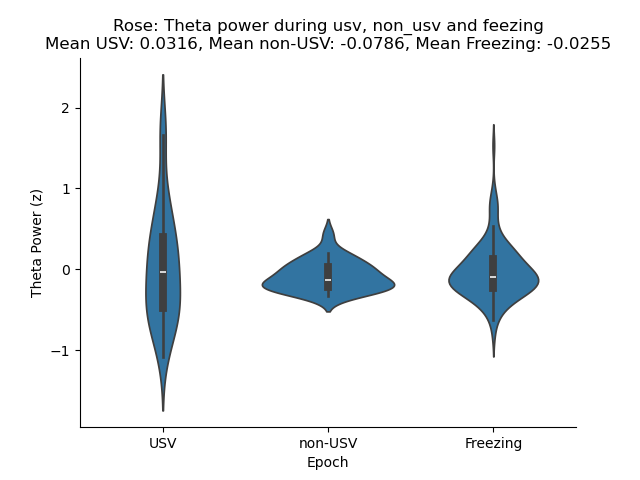

In [40]:
# Easily plot with seaborn
vio1, ax = plt.subplots()

title_text = f"Rose: Theta power during usv, non_usv and feezing\nMean USV: {theta_power_usvs.mean():.4f}, Mean non-USV: {theta_power_non_usvs.mean():.4f}, Mean Freezing: {theta_power_frz.mean():.4f}"
ax.set_title(title_text)
sns.violinplot(data=theta_power_df, x="Epoch", y="Theta Power")
ax.set_ylabel("Theta Power (z)")
sns.despine(ax=ax)
vio1.savefig('/home/bowenw/Documents/thesisplots/Rose usv nonusv thetapower violinplot.png')

In [41]:
theta_power_usvs

array([ 0.58536711, -0.21431873,  0.12505482,  0.41760634,  1.12703748,
        0.27883317,  0.19135491,  0.37530878, -0.48569344,  0.75170591,
       -0.67371642, -0.33578017,  0.1171071 , -0.8579839 , -0.26077164,
       -1.08067936, -1.02720023, -0.14327523,  0.10231134, -0.47400129,
       -0.44169831, -0.21739462, -0.7084075 , -0.33030244, -0.66782174,
       -0.67828304,  0.75668829, -0.61909543, -0.4427132 ,  0.50743764,
        0.32267622,  0.16582526,  0.81821172,  1.74500348,  1.73878536,
        1.65549958,  0.64709657, -0.54450126, -0.72152271, -0.31662326,
        0.15163739, -0.03865911,  0.06016991])

In [42]:
theta_power_non_usvs

array([-0.24675283, -0.24801994,  0.02614697,  0.06540286,  0.17262431,
       -0.09632151, -0.15229744, -0.20370429, -0.21236374,  0.20033405,
       -0.26120704,  0.42954472, -0.05882689,  0.08617419, -0.22626905,
       -0.26017375, -0.12962809, -0.31403733,  0.178091  , -0.04644668,
       -0.02941557, -0.16211904, -0.32979307, -0.14888054, -0.20967424,
        0.02984848,  0.02604421])

In [43]:
import pingouin as pg
pg.pairwise_tests(data=theta_power_df, dv="Theta Power", between="Epoch", padjust="bonf")

Contrast         A        B  Paired  Parametric         T        dof  \
0    Epoch  Freezing      USV   False        True -0.510166  49.235090   
1    Epoch  Freezing  non-USV   False        True  1.124363  72.201816   
2    Epoch       USV  non-USV   False        True  0.973589  50.690391   

  alternative     p-unc   p-corr p-adjust   BF10    hedges  
0   two-sided  0.612215  1.00000     bonf  0.213 -0.122324  
1   two-sided  0.264583  0.79375     bonf  0.387  0.164942  
2   two-sided  0.334884  1.00000     bonf  0.376  0.192710

In [44]:
theta_power_frz

array([-0.12902334, -0.19211845, -0.33638674, -0.13544221,  0.09118851,
       -0.39528869, -0.02187777, -0.34575343, -0.17673946, -0.09515017,
       -0.37780042, -0.28935199,  0.03286727,  0.10107187, -0.25974466,
       -0.20504631, -0.26271601, -0.16807645, -0.38345156, -0.21660384,
        0.8043665 ,  0.16135333, -0.18223816, -0.3074502 , -0.17080076,
        0.97284009, -0.38585771, -0.58077935, -0.366878  , -0.08217071,
        0.03749818,  0.30389818,  0.67567816, -0.24972304, -0.01069833,
        0.86702392,  0.13890105,  0.18502188,  0.1881323 , -0.0967609 ,
       -0.13263364, -0.20675179,  0.10279177, -0.24218232, -0.13814491,
       -0.16211979, -0.23791051, -0.09476174,  0.01459034,  0.30205815,
        0.10523698, -0.35862133,  0.13079693,  0.33373947,  0.22086238,
        0.20641132, -0.11469056,  0.11834549,  1.52934613,  0.18708704,
       -0.04969178,  0.77332055,  0.28019825,  0.07224752,  0.25125001,
        0.47003835,  0.22591427,  0.00340689, -0.02773904, -0.02

# SWR

In [45]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 25
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
exclude_ripple_epochs = False  # make this true if you end up with a lot of false positive ripples as gamma events during ripple

if not exclude_ripple_epochs:
    ripple_epochs, ripple_power = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    ripple_epochs, ripple_power = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff,
                                         ignore_epochs=art_epochs.__add__(ripple_epochs), return_power=True)
sess.recinfo.write_epochs(ripple_epochs, ext='swr')
ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
ripple_epochs.save(ripple_epochs_file)

Selected channels for ripples: [25]
17369 epochs remaining with durations within (0.05,0.45)
/data2/Trace_FC/Recording_Rats/Rose/2022_06_22_training/Rose_training_denoised.ripple_epochs.npy saved


In [46]:
ripple_power_sg = core.signal.Signal(ripple_power, signal.sampling_rate)

In [47]:
signal.time_slice(t_start=usv_epochs.starts[0], t_stop=usv_epochs.stops[0])
ripple_power_sg = core.signal.Signal(ripple_power, signal.sampling_rate)
ripple_power_usvs, ripple_power_non_usvs = [], []
ripple_power_sg = core.signal.Signal(ripple_power, signal.sampling_rate)
for usv_epoch, usv_next_epoch in zip(usv_epochs, usv_epochs[1:]):

    power_slice = ripple_power_sg.time_slice(t_start=usv_epoch.starts, t_stop=usv_epoch.stops)
    ripple_power_usvs.append(power_slice.traces[0].mean())

    power_slice = ripple_power_sg.time_slice(t_start=usv_epoch.starts, t_stop=usv_next_epoch.starts)
    ripple_power_non_usvs.append(power_slice.traces[0].mean())

ripple_power_usvs = np.array(ripple_power_usvs)
ripple_power_non_usvs = np.array(ripple_power_non_usvs)

In [48]:
ripple_power_usvs.mean()

-0.31733248485288645

In [49]:
ripple_power_non_usvs.mean()

-0.06476897946491411

In [50]:
# Make above into pandas DataFrame for easy plotting with seaborn

df1 = pd.DataFrame({"ripple Power": ripple_power_usvs, "Epoch": "USV"})
df2 = pd.DataFrame({"ripple Power": ripple_power_non_usvs, "Epoch": "non-USV"})
ripple_power_df = pd.concat((df1, df2), axis=0).reset_index()
ripple_power_df

index  ripple Power    Epoch
0       0     -0.571939      USV
1       1      1.060769      USV
2       2     -1.440393      USV
3       3     -0.817753      USV
4       4     -0.661021      USV
..    ...           ...      ...
79     37     -0.133033  non-USV
80     38      0.160222  non-USV
81     39      0.244297  non-USV
82     40      0.020210  non-USV
83     41      0.250904  non-USV

[84 rows x 3 columns]

## usv/nonusv ripple power

In [51]:
recording_duration = 3000 
ripple_power_usvs = []
ripple_power_non_usvs = []

for i, usv_epoch in enumerate(usv_epochs):
    # Vectorized comparison to check if any t_stop_eeg value exceeds recording_duration
    exceed_indices = usv_epoch._epochs.t_stop_eeg > recording_duration
    
    # Vectorized assignment to adjust those t_stop_eeg values
    usv_epoch._epochs.loc[exceed_indices, 't_stop_eeg'] = recording_duration

    # Assuming usv_epoch._epochs is a DataFrame and t_start_eeg, t_stop_eeg are its columns
    t_start = usv_epoch._epochs.t_start_eeg.iloc[0]  # Assuming you're working with the first row
    t_stop = min(usv_epoch._epochs.t_stop_eeg.iloc[0], recording_duration)

    # Slice ripple power using adjusted start and stop times
    power_slice = ripple_power_sg.time_slice(t_start=t_start, t_stop=t_stop)
    ripple_power_usvs.append(power_slice.traces[0].mean())

    # Preparing for the next start comparison, handling the last epoch separately
    if i + 1 < len(usv_epochs):
        next_start = usv_epochs[i + 1]._epochs.t_start_eeg.iloc[0]
    else:
        next_start = recording_duration  # Default to recording_duration for the last epoch

    # Interval check and ripple power calculation for non-USVs
    if t_stop < next_start and (next_start - t_stop) > 2:
        power_slice = ripple_power_sg.time_slice(t_start=t_stop, t_stop=next_start)
        ripple_power_non_usvs.append(power_slice.traces[0].mean())

# Convert lists to numpy arrays
ripple_power_usvs = np.array(ripple_power_usvs)
ripple_power_non_usvs = np.array(ripple_power_non_usvs)

# Create DataFrames and concatenate
df1 = pd.DataFrame({"Ripple Power": ripple_power_usvs, "Epoch": "USV"})
df2 = pd.DataFrame({"Ripple Power": ripple_power_non_usvs, "Epoch": "non-USV"})
ripple_power_df = pd.concat([df1, df2], axis=0).reset_index(drop=True)

ripple_power_df

Ripple Power    Epoch
0       1.029076      USV
1      -0.015744      USV
2       0.763531      USV
3       0.832317      USV
4       0.778335      USV
..           ...      ...
65      0.198395  non-USV
66      0.824025  non-USV
67      0.105369  non-USV
68      1.061139  non-USV
69      0.232670  non-USV

[70 rows x 2 columns]

<Axes: title={'center': 'Han: Ripple Power during USV and Non-USV\nMean USV: 0.3429, Mean non-USV: 0.3403'}, xlabel='Epoch', ylabel='Ripple Power'>

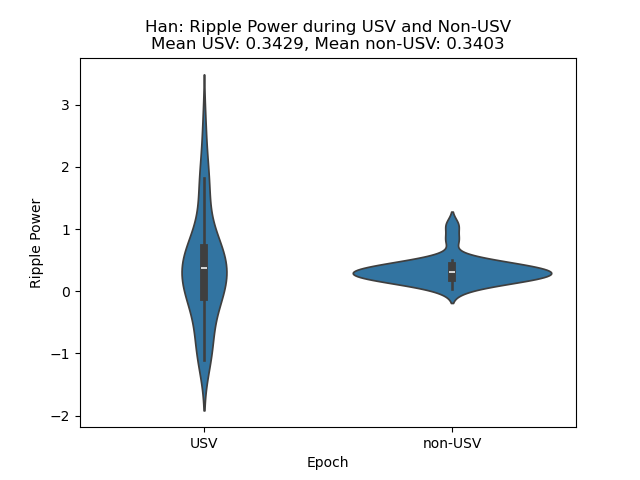

In [52]:
_, ax = plt.subplots()
title_text = f"Han: Ripple Power during USV and Non-USV\nMean USV: {ripple_power_usvs.mean():.4f}, Mean non-USV: {ripple_power_non_usvs.mean():.4f}"
ax.set_title(title_text)
sns.violinplot(data=ripple_power_df, x="Epoch", y="Ripple Power", ax=ax)


## ripple power during usv/nonusv/frz

In [186]:
ripple_power_frz = []
ripple_power_sg = core.signal.Signal(ripple_power, signal.sampling_rate)
for frz_epoch in frz_epochs:

    power_slice = ripple_power_sg.time_slice(t_start=frz_epoch.starts, t_stop=frz_epoch.stops)
    ripple_power_frz.append(power_slice.traces[0].mean())

ripple_power_frz = np.array(ripple_power_frz)

frz_df = pd.DataFrame({"Ripple Power": ripple_power_frz, "Epoch": "Freezing"})
ripple_power_df = pd.concat((df1, df2, frz_df), axis=0).reset_index()

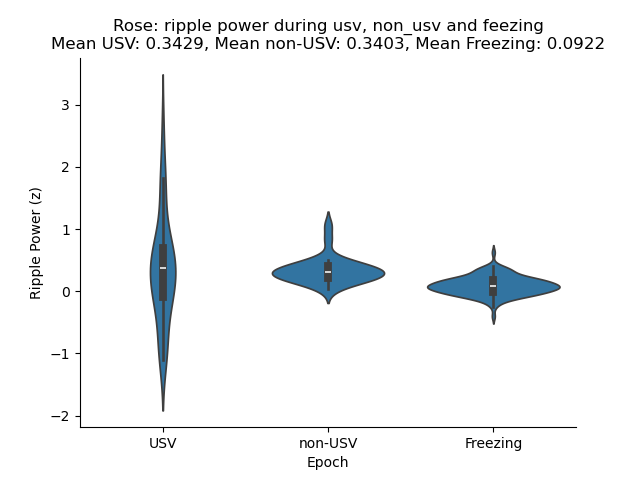

In [187]:
# Easily plot with seaborn
vio1j, ax = plt.subplots()

title_text = f"Rose: ripple power during usv, non_usv and feezing\nMean USV: {ripple_power_usvs.mean():.4f}, Mean non-USV: {ripple_power_non_usvs.mean():.4f}, Mean Freezing: {ripple_power_frz.mean():.4f}"
ax.set_title(title_text)
sns.violinplot(data=ripple_power_df, x="Epoch", y="Ripple Power")
ax.set_ylabel("Ripple Power (z)")
sns.despine(ax=ax)
vio1j.savefig('/home/bowenw/Documents/thesisplots/Rose usv nonusv ripplepower violinplot1.png')

In [188]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Correct the y-axis label to match the DataFrame's column name exactly
# vio1j, ax = plt.subplots()
# title_text = f"Rose: Ripple Power during USV, Non-USV, and Freezing\nMean USV: {ripple_power_usvs.mean():.4f}, Mean non-USV: {ripple_power_non_usvs.mean():.4f}, Mean Freezing: {ripple_power_frz.mean():.4f}"
# ax.set_title(title_text)
# sns.violinplot(data=ripple_power_df, x="Epoch", y="Ripple Power", ax=ax)  # Corrected "ripple Power" to "Ripple Power"
# ax.set_ylabel("Ripple Power (z)")  # Corrected label to match the column name exactly
# sns.despine(ax=ax)
# vio1j.savefig('/home/bowenw/Documents/thesisplots/Rose usv nonusv ripplepower violinplot2.png')

In [189]:
# # Easily plot with seaborn
# vio1, ax = plt.subplots()

# title_text = f"Rose: Ripple power during usv, non_usv and feezing\nMean USV: {ripple_power_usvs.mean():.4f}, Mean non-USV: {ripple_power_non_usvs.mean():.4f}, Mean Freezing: {theta_power_frz.mean():.4f}"
# ax.set_title(title_text)
# sns.violinplot(data=ripple_power_df, x="Epoch", y="Ripple Power")
# ax.set_ylabel("Ripple Power (z)")
# sns.despine(ax=ax)
# vio1.savefig('/home/bowenw/Documents/thesisplots/Rose usv nonusv ripplepower violinplot.png')

In [57]:
ripple_power_usvs

array([ 1.02907639, -0.0157436 ,  0.76353138,  0.83231672,  0.77833534,
       -0.7324103 , -0.9146315 ,  0.43735572,  0.52808373,  0.4510086 ,
        0.32644209, -0.06109027,  1.62766607,  1.6865675 , -0.08693101,
       -0.03838535, -1.04132036,  0.41347201, -0.01548534,  0.12691918,
       -0.11663702,  0.29074123, -0.11296152,  0.48846235, -0.74335943,
       -1.10861356,  0.53130408,  0.04950068, -0.85174352,  0.39767358,
       -0.30431789,  0.18395694,  0.53220724,  2.67810852,  1.82067294,
       -0.98652737,  0.93341735, -0.20259386,  0.36605852,  0.49765486,
        2.16525473,  1.52696576,  0.61466625])

In [58]:
ripple_power_non_usvs

array([0.49373223, 0.44148996, 0.33354843, 0.16664276, 0.28376617,
       0.28258172, 0.17726898, 0.31225741, 0.36232703, 0.26259225,
       0.27651773, 0.42215346, 0.40304501, 0.03005964, 0.50858004,
       0.16672811, 0.41732979, 0.36238341, 0.32241396, 0.33217425,
       0.22239572, 0.18660364, 0.19839504, 0.82402544, 0.10536889,
       1.06113885, 0.23267003])

In [59]:
ripple_power_frz

array([-0.14996851,  0.36582709, -0.1258305 , -0.18139854, -0.12091252,
       -0.0385272 ,  0.05527033, -0.00925181,  0.04152712,  0.00586045,
        0.1878676 ,  0.04630777, -0.07651226,  0.0611919 ,  0.28184718,
        0.06274752,  0.15737803,  0.15426049, -0.01732966, -0.03560541,
        0.25355612,  0.40359068,  0.06740387,  0.04246467, -0.07299288,
        0.02932978,  0.15816531, -0.03316659,  0.32898868, -0.10033599,
       -0.18766604, -0.03325208, -0.07112538, -0.03486229,  0.00351891,
        0.39465333,  0.20504346,  0.32473894,  0.25899224,  0.06812005,
        0.05497658,  0.13945673,  0.18373814,  0.01131624, -0.06880269,
        0.07197993, -0.02279677,  0.0907912 , -0.0982279 ,  0.09120914,
        0.15225236,  0.06411404, -0.03713462,  0.20880869,  0.08189356,
        0.36800182, -0.02715396,  0.16457001,  0.09052901,  0.35278027,
        0.00173589,  0.17859894,  0.22961023,  0.24047922,  0.12576961,
       -0.01203676,  0.08619967,  0.05987763, -0.01528344,  0.15

In [60]:
import pingouin as pg
pg.pairwise_tests(data=ripple_power_df, dv="ripple Power", between="Epoch", padjust="bonf")

AssertionError: y cannot be an empty list or array.

In [ ]:
import pandas as pd
import numpy as np

recording_duration = 3000  # Ensure this is defined

# Initialize lists to hold theta power values
theta_power_highusvs = [] 
theta_power_lowusvs = []
theta_power_usvs = []  # Ensure you use this if needed
theta_power_non_usvs = []  # Ensure you use this if needed

# Assuming usv_epochs is a list of objects and each object has an _epochs attribute that behaves like a DataFrame
for usv_epoch in usv_epochs:
    # Vectorized operation to adjust t_stop_eeg values
    usv_epoch._epochs.loc[usv_epoch._epochs.t_stop_eeg > recording_duration, 't_stop_eeg'] = recording_duration

    freq_min = usv_epoch.to_dataframe()['Freq_Min'].values[0]  # Frequency check
    
    # Assuming ripple_power_sg.time_slice() can handle these values directly
    t_start = usv_epoch._epochs.t_start_eeg.iloc[0]  # First row's value
    t_stop = min(usv_epoch._epochs.t_stop_eeg.iloc[0], recording_duration)
    
    if freq_min > 23:
        power_slice = ripple_power_sg.time_slice(t_start=t_start, t_stop=t_stop)
        theta_power_highusvs.append(power_slice.traces[0].mean())
    elif freq_min <= 23:
        power_slice = ripple_power_sg.time_slice(t_start=t_start, t_stop=t_stop)
        theta_power_lowusvs.append(power_slice.traces[0].mean())

# Conversion to numpy arrays after all append operations
theta_power_lowusvs = np.array(theta_power_lowusvs)
theta_power_highusvs = np.array(theta_power_highusvs)

# DataFrames creation and concatenation
df1 = pd.DataFrame({"Theta Power": theta_power_usvs, "Epoch": "USV"})
df2 = pd.DataFrame({"Theta Power": theta_power_lowusvs, "Epoch": "LowUSV"})
df3 = pd.DataFrame({"Theta Power": theta_power_highusvs, "Epoch": "HighUSV"})
df4 = pd.DataFrame({"Theta Power": theta_power_non_usvs, "Epoch": "non-USV"})
theta_power_df = pd.concat([df1, df2, df3, df4], axis=0).reset_index(drop=True)

theta_power_df

## Only have high usv, no need for usv during frz/nonfrz analysis